In [1]:
import pandas as pd
import numpy as np
import gc
import imp
import sys
from scipy import stats
from notebooks_functions import *
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
import matplotlib.colors as colors
import matplotlib.font_manager as font_manager

%matplotlib inline

setup_mpl()
f_size= 14

In [2]:
measure = 'retur'
corr_couples = pd.read_pickle(f'export/robustness/rp_{measure}_win{120}.pkl')
sample_time = pd.read_pickle(f'export/robustness/rpRT_{measure}_win{120}.pkl')
corr_couples.index = corr_couples.index.days
sample_time.index = sample_time.index.days

def new_dist(window_size):

    bounds = (-2.51,2.51)
    slide=1
    transient_length = 75 # 75 # ~ life della transizione secondo il modello
    # select the correlation before and after the connection time for the sample_time dataframe
    sample = sample_time.loc[-int(window_size/slide):-1]
    sample = sample.mean().reset_index().rename(columns={'index':'name',0:'before'})
    sample['after'] = sample_time.loc[int(transient_length/slide):int(transient_length/slide)+int(window_size/slide)].mean().values
    sample = sample.dropna()
    sample.reset_index(drop=True)
    # select the correlation before and after the connection time for the collaborative cryptocurrencies
    couples = corr_couples.loc[-int(window_size/slide):-1]
    couples = couples.mean().reset_index().rename(columns={'index':'name',0:'before'})
    couples['after'] = corr_couples.loc[int(transient_length/slide):int(transient_length/slide)+int(window_size/slide)].mean().values
    couples = couples.dropna()
    couples.reset_index(drop=True,inplace=True)
    df = couples.copy() # required in following cells (3 below)
    df.reset_index(drop=True,inplace=True)
    couple_distance = (couples.after-couples.before)
    sample_distance = (sample.after-sample.before)
    
    return couple_distance,sample_distance

## Main Text: Figure 3

0.39275637632995297


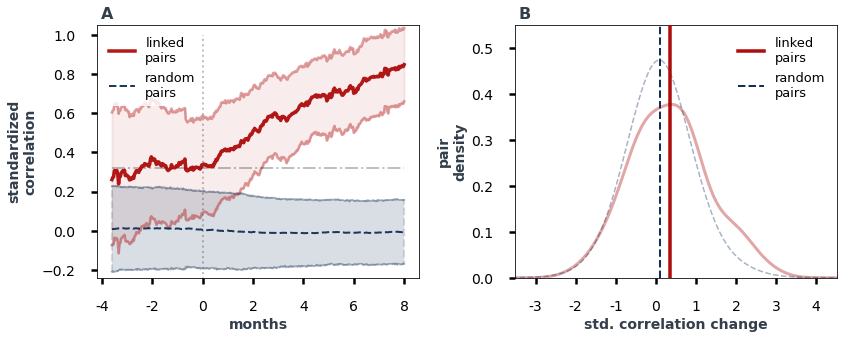

In [6]:

###### Run before  FIGURE 3
fraction = 0.15  # discard timeseries values if a fraction of less than "fraction" has non nan value at a step
slide = 1                 # number of days we are sliding for
min_index = -108
max_index = 91+150
months_for_corr = 4
rmin = -5.01
rmax = 5.51
p_ind = 250
bins=20
lwavg = 3.5
lwkde = 3
size=16
log = False 
x_symlog = False
### Fig3(A)
# ###### Prepare data for fit and plot

sCC = pd.read_pickle(f'export/sCC_summary_{measure}_10000_win120.pkl')
sCC = sCC.loc[(sCC.active_cryptos/max(sCC.active_cryptos)>fraction)&(sCC.index.days<max_index)&(sCC.index.days>=min_index)]
sRT = pd.read_pickle(f'export/sRT_summary_{measure}_10000_win120.pkl')
sRT = sRT.loc[sCC.index]


mpl.rcParams['lines.linewidth']=2

###### FIGURE 3 
### Figure generation
confidence = 0.95
cut=0.5
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
fig, ax = plt.subplots(figsize=(12,5))
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
ax1 = plt.subplot(121)
ax1.plot((sCC.index.days*slide)/30,sCC['avg'],linewidth=lwavg,alpha=.9, color='#AB0000', 
         zorder=5,label='linked\npairs')
conf1 = 2*sCC['sem_N'].values
ax1.fill_between((sCC.index.days*slide)/30,sCC['avg_N']+conf1,sCC['avg_N']-conf1, # standard error of the mean
                 color='#AB0000', linewidth=2, zorder=2, alpha=0.075)#, label = '2 std  error')
ax1.plot((sCC.index.days*slide)/30,sCC['avg_N'].values+conf1,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')
ax1.plot((sCC.index.days*slide)/30,sCC['avg_N'].values-conf1,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')

ax1.plot(sRT.index.days*slide/30,sRT['avg'],linestyle='--',linewidth=2,
        alpha=.9, color='#06244C', zorder=5, label='random\npairs')
confRT1 = 2*sRT['sem_N'].values
ax1.fill_between((sRT.index.days*slide)/30,sRT['avg_N']+confRT1,sRT['avg_N']-confRT1,linestyle='--', # standard error of the mean
                 color='#06244C', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
ax1.plot((sRT.index.days*slide)/30,sRT['avg_N'].values+confRT1,color='#06244C', linewidth=lwavg-lwavg/2, zorder=2, alpha=0.35)
ax1.plot((sRT.index.days*slide)/30,sRT['avg_N'].values-confRT1,color='#06244C', linewidth=lwavg-lwavg/2, zorder=2, alpha=0.35)

ax1.plot((min((sCC.index.days*slide)/30),max((sCC.index.days*slide)/30)),
            (sCC.loc[:'-1 days'].avg.mean(),sCC.loc[:'-1 days'].avg.mean()),
            '-.',color='k',alpha=0.25)#,label = 'connected average\nbefore')
ax1.plot((0,0),(-.3,1.),':',color='k',alpha=0.25)#, label='connection \ntime')


ax1.set_ylim((-0.24,1.05))
ax1.set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
ax1.set_ylabel('standardized\ncorrelation', fontsize = f_size,fontweight='black',color = '#333F4B')
ax1.set_xticks([-4,-2,0,2,4,6,8])
ax1.set_xticklabels([-4,-2,0,2,4,6,8])
ax1.tick_params('both',labelsize=f_size)
ax1.tick_params(axis='x', colors='#000000')

ax1.legend(fontsize = f_size-1,frameon=True, loc=2, edgecolor='#FFFFFF')


#### ################################################################################################
couple_distance, sample_distance = new_dist(120)
log = False 
x_symlog = False
tune_bw = stats.gaussian_kde(couple_distance).covariance_factor()+0.

ax3 = plt.subplot(122)
### KDES
couple_distance.plot.kde(ax=ax3, ind=p_ind, linestyle='-', color='#AB0000', linewidth=lwkde, alpha=0.35,zorder=4,
        bw_method=tune_bw, label='_nolegend_')
sample_distance.plot.kde(ax=ax3, ind=p_ind, linestyle='--', color='#06244C',linewidth=lwkde-1.5, alpha=0.35,zorder=4,
        bw_method=tune_bw, label='_nolegend_')

# ### HISTOGRAMS
# couple_distance.hist(ax=ax3, bins=bins,range=(-3,3), linestyle='-.', color='#AF2332', linewidth=lwkde, alpha=0.25,zorder=4,
#         density=True)
# sample_distance.hist(ax=ax3, bins=bins,range=(-3,3), linestyle='-', color='#194795',linewidth=lwkde, alpha=0.25,zorder=4,
#         density=True)
# couple_distance.hist(ax=ax3, bins=bins,range=(-3,3), linestyle='-.', color='#AF2332', linewidth=lwkde, alpha=0.5,zorder=4,
#         density=True,histtype='step')
# sample_distance.hist(ax=ax3, bins=bins,range=(-3,3), linestyle='-', color='#194795',linewidth=lwkde, alpha=0.5,zorder=4,
#         density=True,histtype='step')
ax3.axvline(couple_distance.mean(), linestyle='-',color='#AB0000',alpha=0.95,zorder=5, linewidth=lwavg,label = 'linked\npairs')
ax3.axvline(sample_distance.mean(), linestyle='--',color='#06244C',alpha=0.95,zorder=5, linewidth=lwavg-1.5,label = 'random\npairs')

ax3.grid(False)
# ax3.tick_params('#491A65', labelsize=size, colors='#491A65')
ax3.tick_params('both',labelsize=f_size)
ax3.set_xlim((-3.51,4.51))
ax3.set_ylim((.00,.55))
ax3.set_ylabel('pair\ndensity',fontsize=f_size,fontweight='black',color = '#333F4B')
ax3.set_xlabel('std. correlation change',fontsize=f_size,fontweight='black',color = '#333F4B')
if log:
    ax3.set_yscale('log')
if x_symlog:
    ax3.set_xscale('symlog', linthreshy=0.05)
ax3.legend(fontsize=f_size-1, frameon=False)
ax3.set_xticks([-3,-2,-1,0,1,2,3,4])
ax3.set_xticklabels([-3,-2,-1,0,1,2,3,4])

ax1.text(0.01,1.025,'A',fontsize=f_size+2, transform=ax1.transAxes, weight='black',color='#333F4B')
ax3.text(0.01,1.025,'B',fontsize=f_size+2, transform=ax3.transAxes, weight='black',color='#333F4B')


plt.tight_layout()
fig.subplots_adjust(wspace=.3,hspace=0.1)
plt.savefig('figures/3_rebuttal.pdf')

print(tune_bw)

## Main Text: Figure 4

In [7]:
# ### Market caitalization and transaction volume distributions
measure = 'retur'
conn_couples = pd.read_pickle('conn_couples.pkl')

mrcap = pd.read_pickle('export/df_mrcap.pkl')
trvol = pd.read_pickle('export/df_volum.pkl')
couples = pd.read_pickle('conn_couples.pkl')
size =120
dens = False
nbin1 = 11
nbin2 = 11
up1 = 11
up2 = 9
lo1 = 6
lo2 = 4.5
mrcapdiffs = []
trvoldiffs = []
Rmrcapdiffs = []
Rtrvoldiffs = []
mrcapdiffsB = []
mrcapdiffsA = []
trvoldiffsB = []
trvoldiffsA = []
RmrcapdiffsB = []
RmrcapdiffsA = []
RtrvoldiffsB = []
RtrvoldiffsA = []
org1_ages = (couples.coll_begins-couples.coin_age1).dt.days
org2_ages = (couples.coll_begins-couples.coin_age2).dt.days
ages = list(org1_ages)+list(org2_ages)
agediffs = list(org1_ages-org2_ages)

for i,couple in couples.iterrows():
    tmpMr = mrcap[[couple.org1,couple.org2]].loc[couple.coll_begins-pd.Timedelta(size,'d'):couple.coll_begins+pd.Timedelta(size,'d')].dropna()
    if len(tmpMr)>0:
        mrcapdiffs.append(np.abs(tmpMr.mean().diff()[1]))
    RtmpMr = mrcap.loc[couple.coll_begins-pd.Timedelta(size,'d'):couple.coll_begins+pd.Timedelta(size,'d')].dropna(axis=1).drop('year',axis=1).mean()
    combos = itertools.combinations(RtmpMr,2)
    for a,b in combos:   
        Rmrcapdiffs.append(np.abs(a-b))

    tmpVol = trvol[[couple.org1,couple.org2]].loc[couple.coll_begins-pd.Timedelta(size,'d'):couple.coll_begins+pd.Timedelta(size,'d')].dropna()
    if len(tmpVol)>0:
        trvoldiffs.append(np.abs(tmpVol.mean().diff()[1]))
    RtmpVol = trvol.loc[couple.coll_begins-pd.Timedelta(size,'d'):couple.coll_begins+pd.Timedelta(size,'d')].dropna(axis=1).drop('year',axis=1).mean()
    combos = itertools.combinations(RtmpVol,2)
    for a,b in combos:   
        Rtrvoldiffs.append(np.abs(a-b))
#     print('progress... {}%\t\t'.format(round(i/len(couples)*100,2)),end='\r')

mrcapdiffs = np.array(mrcapdiffs)
trvoldiffs = np.array(trvoldiffs)
Rmrcapdiffs = np.array(Rmrcapdiffs)
Rtrvoldiffs = np.array(Rtrvoldiffs)
mrcapdiffsB = np.array(mrcapdiffsB)
mrcapdiffsA = np.array(mrcapdiffsA)
trvoldiffsB = np.array(trvoldiffsB)
trvoldiffsA = np.array(trvoldiffsA)
RmrcapdiffsB = np.array(RmrcapdiffsB)
RmrcapdiffsA = np.array(RmrcapdiffsA)
RtrvoldiffsB = np.array(RtrvoldiffsB)
RtrvoldiffsA = np.array(RtrvoldiffsA)


### Compute age differences
pri = pd.read_pickle('export/df_price.pkl')
lp = pd.read_pickle('conn_couples.pkl')
rt = pd.read_pickle('rand_conn_time_couples.pkl')

# Market age
old_market_age = lp.apply(lambda x: max(x.coll_begins-pri[x.org1].first_valid_index(),x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
new_market_age = lp.apply(lambda x: min(x.coll_begins-pri[x.org1].first_valid_index(),x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
market_agediff = np.abs(old_market_age-new_market_age)

Rold_market_age = rt.apply(lambda x: max(x.coll_begins-pri[x.org1].first_valid_index(),x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
Rnew_market_age = rt.apply(lambda x: min(x.coll_begins-pri[x.org1].first_valid_index(),x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
Rmarket_agediff = np.abs(Rold_market_age-Rnew_market_age)


Rmrc = Rmrcapdiffs[(Rmrcapdiffs<2e11)]
mrc = mrcapdiffs[(mrcapdiffs<2e11)]
# inc_mrc = inc_mrcapdiffs[(inc_mrcapdiffs<2e11)]
Rtrv = Rtrvoldiffs[(Rtrvoldiffs>0)&(Rtrvoldiffs<2e11)]
trv = trvoldiffs[(trvoldiffs>0)&(trvoldiffs<2e11)]
# inc_trv = inc_trvoldiffs[(inc_trvoldiffs>0)&(inc_trvoldiffs<2e11)]
market_agediff = market_agediff[market_agediff>0]
Rmarket_agediff = Rmarket_agediff[Rmarket_agediff>0]

M1 = pd.Series(np.log10(mrc))
RM1 = pd.Series(np.log10(Rmrc))
V1 = pd.Series(np.log10(trv))
RV1 = pd.Series(np.log10(Rtrv))
A1 = pd.Series(np.log10(market_agediff))
RA1 = pd.Series(np.log10(Rmarket_agediff))


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


0.3597314285810944
0.3610459511804155
0.34520252721983885


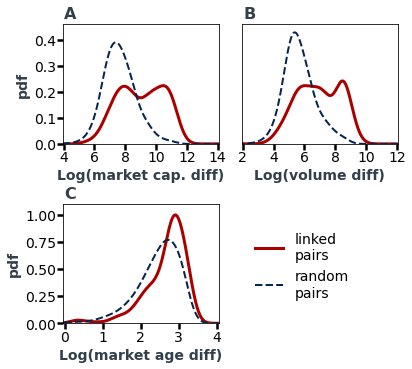

In [8]:
### ################# ################# ################# ################# ################# ################# ##############
### ################# ################# ################# ################# ################# ################# ##############
### ############## plot ### ################# ################# ################# ################# ################# ########
### ################# ################# ################# ################# ################# ################# ##############
### ################# ################# ################# ################# ################# ################# ##############
### 1.1 plot -- market cap differences
### Tabella in cui riassumiamo i valori di guadagno in correlazione rispetto alla media di tutta l'ecologia
### (e plot con linee e punti per anno) ... per girare LANCIARE la CELLA PRECEDENTE!!!
### corr_couples, corr_githubs, corr_backgro, std_couples, std_githubs, std_backgro
fig = plt.figure(figsize=(6,5.5),facecolor='white')
size = 14
ax = plt.subplot(2,2,1)
tune1 = stats.gaussian_kde(M1).covariance_factor()
### KDES
## Plot numpy histograms of the couples differences distributions (x= diff, y=percentage of cryptocouples)
km1 = M1.plot.kde(bw_method=tune1, ax=ax, linestyle='-', color='#AB0000',label='linked\npairs',lw=3)
## Plot numpy histograms of the background differences distributions (x= diff, y=percentage of cryptocouples)
# pd.Series(np.log10(inc_mrc)).plot.kde(bw_method=tune, linestyle='--', alpha=0.5, color='#960000',label='increasing\npairs')
krm1 = RM1.plot.kde(bw_method=tune1, ax=ax, linestyle='--',color='#06244C',label='random\npairs')


ax.grid(False)
ax.set_ylabel('pdf',fontsize=f_size, fontweight='black',color = '#333F4B')
ax.set_xlabel('Log(market cap. diff)',fontsize=f_size, fontweight='black',color = '#333F4B')
ax.set_ylim((0,4.6e-1))
ax.set_xlim((3.95,14.05))


### 1.2 plot -- transaction volume differences
axx = plt.subplot(2,2,2)
tune2 = stats.gaussian_kde(V1).covariance_factor()
### KDES
### Plot numpy kdes of the couples differences distributions (x= diff, y=percentage of cryptocouples)
kv1 = V1.plot.kde(bw_method=tune2, ax=axx, linestyle='-', color='#AB0000',label='linked\npairs',lw=3)
## Plot numpy kdes of the background differences distributions (x= diff, y=percentage of cryptocouples)
krv1 = RV1.plot.kde(bw_method=tune2, ax=axx, linestyle='--', color='#06244C',label='random\npairs')


axx.grid(False)
# axx.legend(fontsize=size,loc=1, frameon=False)
axx.tick_params('y',labelsize=0, colors='#FFFFFF00')

axx.set_ylabel('pdf',fontsize=f_size, fontweight='black',color = '#FFFFFF00')
axx.set_xlabel('Log(volume diff)',fontsize=f_size, fontweight='black',color = '#333F4B')
axx.set_ylim((0,4.6e-1))
axx.set_xlim((1.95,12.05))



### 1.3 plot -- market age differences
axxx = plt.subplot(2,2,3)
tune3 = stats.gaussian_kde(A1).covariance_factor()
### KDES
### Plot numpy kdes of the couples differences distributions (x= diff, y=percentage of cryptocouples)
ka1 = A1.plot.kde(bw_method=tune3, ax=axxx, linestyle='-', color='#AB0000',label='linked\npairs',lw=3)
## Plot numpy kdes of the background differences distributions (x= diff, y=percentage of cryptocouples)
kra1 = RA1.plot.kde(bw_method=tune3, ax=axxx, linestyle='--', color='#06244C',label='random\npairs')

axxx.grid(False)
axxx.legend(fontsize=size,loc=(1.2,0.15), frameon=False)
axxx.set_ylabel('pdf',fontsize=f_size, fontweight='black',color = '#333F4B')
axxx.set_xlabel('Log(market age diff)',fontsize=f_size, fontweight='black',color = '#333F4B')
axxx.set_ylim((0,1.1e0))
axxx.set_xlim((-0.05,4.05))

axxx.text(0.01,1.05,'C',fontsize=f_size+2, transform=axxx.transAxes, weight='black',color='#333F4B')
axx.text(0.01,1.05,'B',fontsize=f_size+2, transform=axx.transAxes, weight='black',color='#333F4B')
ax.text(0.01,1.05,'A',fontsize=f_size+2, transform=ax.transAxes, weight='black',color='#333F4B')
axxx.tick_params('both',labelsize=size, colors='#000000')
axx.tick_params('x',labelsize=size, colors='#000000')
ax.tick_params('both',labelsize=size, colors='#000000')
axxx.tick_params(axis='both',pad=.5)
axx.tick_params(axis='both',pad=.5)
ax.tick_params(axis='both',pad=.5)

ax.set_xticks([4,6,8,10,12,14])
axx.set_xticks([2,4,6,8,10,12])
axxx.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6,8,10,12,14])
axx.set_xticklabels([2,4,6,8,10,12])
axxx.set_xticklabels([0,1,2,3,4])

ax.set_yticks([0,.1,.2,.3,.4])
axxx.set_yticks([0,0.25,.5,.75,1.])
ax.set_yticks([0,.1,.2,.3,.4])
axxx.set_yticks([0,0.25,.5,.75,1.])

# plt.tight_layout()
fig.subplots_adjust(wspace=.15,hspace=0.5)
plt.savefig('figures/4_rebuttal.pdf')

print(tune1)
print(tune2)
print(tune3)

In [9]:
### Evaluate possible differences in market cap an transaction volume (k-s test and t-test)
print('KStest: MrCap Diffs',stats.ks_2samp(mrc,Rmrc)[0:2])
print('Ttest: MrCap Diffs',stats.ttest_ind(mrc,Rmrc,equal_var=False,nan_policy='omit')[0:2])
print('')
print('KStest: TrVol Diffs',stats.ks_2samp(trv,Rtrv)[0:2])
print('Ttest: TrVol Diffs',stats.ttest_ind(trv,Rtrv,equal_var=False,nan_policy='omit')[0:2])
print('')
print('KStest: TrVol Diffs',stats.ks_2samp(market_agediff,Rmarket_agediff)[0:2])
print('Ttest: TrVol Diffs',stats.ttest_ind(market_agediff,Rmarket_agediff,equal_var=False,nan_policy='omit')[0:2])

KStest: MrCap Diffs (0.42580608096250516, 1.4435688147595424e-26)
Ttest: MrCap Diffs (6.497017652614392, 9.262343583957755e-10)

KStest: TrVol Diffs (0.42786949331564517, 2.413480734810095e-26)
Ttest: TrVol Diffs (6.026060363554121, 1.0945644178754139e-08)

KStest: TrVol Diffs (0.2594584873358363, 2.4992354867036985e-12)
Ttest: TrVol Diffs (5.975714950338024, 1.0099936759360197e-08)


# Supplementary Information

In [10]:
## For supplementary matherial add into "AGE analysis" TODO
measure = 'retur'
pairs_cc = pd.read_pickle('conn_couples.pkl')
pairs_rt = pd.read_pickle('rand_conn_time_couples.pkl')
# Remove connected couples from random couples (as done in notebook 4_pt1)
pairsRT = pairs_rt[['org1','org2','coll_begins']]
pairsRT = pairsRT.merge(pairs_cc[['org1','org2']],on=['org1','org2'], indicator=True,how='left').query('_merge=="left_only"').drop('_merge', axis=1).reset_index(drop=True)
pairsRT = pairsRT.rename(columns={'org1':'org2','org2':'org1'}).merge(pairs_cc[['org1','org2']],on=['org1','org2'], indicator=True,how='left').query('_merge=="left_only"').drop('_merge', axis=1).reset_index(drop=True)
pairsRT.reset_index(drop=True,inplace=True)
pairs_rt = pairsRT.copy()
##
corr_couples = pd.read_pickle(f'export/robustness/rp_{measure}_win120.pkl')
sample_time = pd.read_pickle(f'export/robustness/rpRT_{measure}_win120.pkl')
corr_couples.index = corr_couples.index.days
sample_time.index = sample_time.index.days
##
mrcap = pd.read_pickle('export/df_mrcap.pkl')
trvol = pd.read_pickle('export/df_volum.pkl')
couples = pd.read_pickle('conn_couples.pkl')

slide = 1
bounds = (-2.51,2.51)
window_size = 120 # average over a period of #days the correlation series evaluated in the previous notebook (4)  
transient_length = 75 # ~ life della transizione secondo il modello

# select the correlation before and after the connection time for the sample_time dataframe
sample = sample_time.loc[-int(window_size/slide):-1]
sample = sample.mean().reset_index().rename(columns={'index':'name',0:'before'})
sample['after'] = sample_time.loc[int(transient_length/slide):int(transient_length/slide)+int(window_size/slide)].mean().values
sample = sample.dropna()
sample.reset_index(drop=True)

dfrt = sample.copy() ### needed in cells below
dfrt.reset_index(drop=True,inplace=True)
dfrt['org1'] = pairs_rt.loc[dfrt.name].org1.reset_index(drop=True)
dfrt['org2'] = pairs_rt.loc[dfrt.name].org2.reset_index(drop=True)
dfrt['coll_begins'] = pairs_rt.loc[dfrt.name].coll_begins.reset_index(drop=True)

# select the correlation before and after the connection time for the collaborative cryptocurrencies
couples = corr_couples.loc[-int(window_size/slide):-1]
couples = couples.mean().reset_index().rename(columns={'index':'name',0:'before'})
couples['after'] = corr_couples.loc[int(transient_length/slide):int(transient_length/slide)+int(window_size/slide)].mean().values
couples = couples.dropna()
couples.reset_index(drop=True,inplace=True)
df = couples.copy() # required in following cells (3 below)
df.reset_index(drop=True,inplace=True)
df['org1'] = pairs_cc.loc[df.name].org1.reset_index(drop=True)
df['org2'] = pairs_cc.loc[df.name].org2.reset_index(drop=True)
df['coll_begins'] = pairs_cc.loc[df.name].coll_begins.reset_index(drop=True)


## Supplementary Information: Figure S1

/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: 
The set_smart_bound

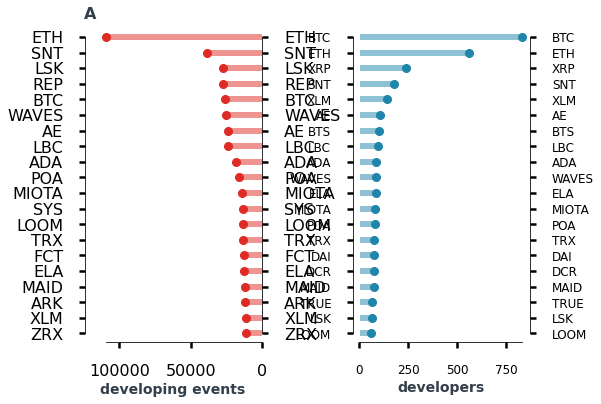

In [11]:
### dataframe con solo push e pull accettate
tmp = pd.read_pickle('export/git_data_pushpull_v4(vol1e5).pkl')

### Distribution: push-events per crypto (top 50, with names)
head_num = 20
df_hist = tmp[(tmp.type=='PushEvent')|(tmp.type=='PullRequestEvent')].groupby('sym').count().reset_index().sort_values('actor_login',ascending=True).tail(head_num)

my_range = range(1,len(df_hist.index)+1)

fig, ax = plt.subplots(1,2,figsize=(8,6))
ax[0].hlines(y=my_range, xmin=1, xmax=df_hist['actor_login'], color='#DE2B25', alpha=0.5, linewidth=6)
ax[0].plot(df_hist['actor_login'], my_range, "o", markersize=8, color='#DE2B25')
ax[0].plot([70000],[10],ms=0)

ax[0].set_yticks(my_range)
ax[0].set_yticklabels(df_hist.sym)
ax[0].set_ylabel('')

ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_smart_bounds(True)
ax[0].spines['left'].set_smart_bounds(True)
ax[0].spines['bottom'].set_smart_bounds(True)
ax[0].spines['bottom'].set_position(('axes', 0.02))
ax[0].spines['left'].set_position(('axes', .01))
ax[0].set_xlabel('developing events', fontsize=f_size, fontweight='black', color = '#333F4B')
ax[0].axes.tick_params(axis='y',left=True,right=True,labelright=True)
ax[0].set_xlim(125000,0)
ax[0].patch.set_facecolor('None')
ax[0].text(0.001,1.01,f'A',fontsize=f_size+2, transform=ax[0].transAxes, weight='black',color='#333F4B')

#####################################################################################################################################

### Distribution: ACTORS per crypto (top 50, with names)
df_hist2 = tmp[~((tmp.type!='PushEvent')&(tmp.type!='PullRequestEvent'))].drop_duplicates(['sym','actor_login']).groupby('sym').count().reset_index().sort_values('actor_login',ascending=True).tail(head_num)

my_range = range(1,len(df_hist2.index)+1)

ax[1].hlines(y=my_range, xmin=1, xmax=df_hist2['actor_login'], color='#2085AA', alpha=0.5, linewidth=6)
ax[1].plot(df_hist2['actor_login'], my_range, "o", markersize=8, color='#2085AA')
ax[1].plot([140],[10],ms=0)

ax[1].set_yticks(my_range)
ax[1].set_yticklabels(df_hist2.sym)
ax[1].set_ylabel('')
ax[1].tick_params(axis='both', which='major', labelsize=f_size-2)

ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_smart_bounds(True)
ax[1].spines['left'].set_smart_bounds(True)
ax[1].spines['bottom'].set_smart_bounds(True)
ax[1].spines['bottom'].set_position(('axes', 0.02))
ax[1].spines['left'].set_position(('axes', .01))
ax[1].set_xlabel('developers', fontsize=f_size, fontweight='black', color = '#333F4B')
ax[1].axes.tick_params(axis='y',left=True,right=True,labelright=True)
ax[1].patch.set_facecolor('None')

plt.subplots_adjust(wspace=0.5)

plt.savefig('figures/S1A_rebuttal.pdf')


/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
/home/llucchini/v2_mobs/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


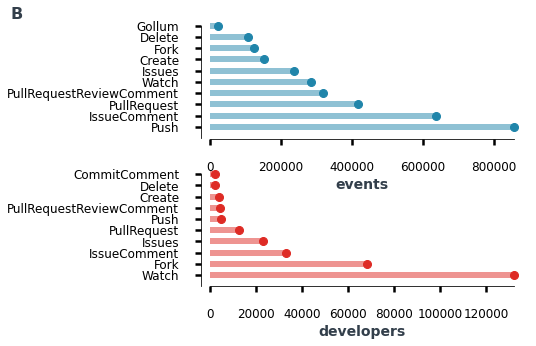

In [12]:
### Number of event per type
tmp = pd.read_pickle('export/git_data_v4(vol1e5).pkl')

df_hist1 = tmp.groupby('type').count().sort_values('id',ascending=False).reset_index().head(10)
my_range = range(1,len(df_hist1.index)+1)

fig, ax = plt.subplots(2,1,figsize=(6,5))
ax[0].hlines(y=my_range, xmin=1, xmax=df_hist1['actor_login'], color='#2085AA', alpha=0.5, linewidth=6)
ax[0].plot(df_hist1['actor_login'], my_range, "o", markersize=8, color='#2085AA')
ax[0].plot([1],[''],ms=0)

ax[0].set_yticks(my_range)
ax[0].set_yticklabels(df_hist1.type.apply(lambda x: x[:-5]))
ax[0].set_xlabel('events', fontsize=f_size, fontweight='black', color = '#333F4B')
ax[0].set_ylabel('')
ax[0].tick_params(axis='both', which='major', labelsize=f_size)

ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_smart_bounds(True)
ax[0].spines['bottom'].set_smart_bounds(True)
ax[0].spines['bottom'].set_position(('axes', 0.04))
ax[0].spines['left'].set_position(('axes', 0.02))
ax[0].patch.set_facecolor('None')
ax[0].tick_params(axis='both', which='major', labelsize=f_size-2)
ax[0].text(-0.55,1.01,f'B',fontsize=f_size+2, transform=ax[0].transAxes, weight='black',color='#333F4B')


### Numer of actors per event type
df_hist = tmp.drop_duplicates(['type','actor_login']).groupby('type').count().sort_values('actor_login',ascending=False).reset_index().head(10)
my_range = range(1,len(df_hist.index)+1)


ax[1].hlines(y=my_range, xmin=1, xmax=df_hist['actor_login'], color='#DE2B25', alpha=0.5, linewidth=6)
ax[1].plot(df_hist['actor_login'], my_range, "o", markersize=8, color='#DE2B25')
ax[1].plot([1],[''],ms=0)

ax[1].set_yticks(my_range)
ax[1].set_yticklabels(df_hist.type.apply(lambda x: x[:-5]))
ax[1].set_xlabel('developers', fontsize=f_size, fontweight='black', color = '#333F4B')
ax[1].set_ylabel('')
ax[1].tick_params(axis='both', which='major', labelsize=f_size-2)

ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_smart_bounds(True)
ax[1].spines['bottom'].set_smart_bounds(True)
ax[1].spines['bottom'].set_position(('axes', 0.05))
ax[1].spines['left'].set_position(('axes', 0.02))
ax[1].patch.set_facecolor('None')


plt.savefig('figures/S1B_rebuttal.pdf')

## Supplementary Information: Figure S3

SpearmanrResult(correlation=0.9181534096900489, pvalue=4.938132851928562e-121)
PearsonrResult (0.7184200141298812, 1.4073325537918053e-48)


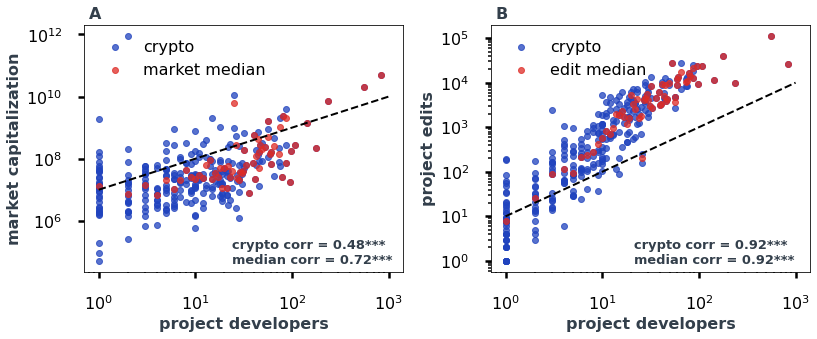

In [180]:
import pandas as pd
## Correlation between number of developers and average market capitalization
git = pd.read_pickle('export/git_data_pushpull_v4(vol1e5).pkl')
developer = git.groupby(['sym','actor_login']).count().reset_index().groupby('sym').count().type
mrcap = pd.read_pickle('export/df_mrcap.pkl')
mrcap = mrcap[git.drop_duplicates('sym').sym.values]

corr_dev_mrcap = developer.reset_index().merge(mrcap.mean().reset_index(),left_on='sym',right_on='index').drop(columns=['index'])
corr_dev_mrcap = corr_dev_mrcap.dropna().set_index('sym')
corr_dev_mrcap = corr_dev_mrcap.rename(columns={'type':'x',0:'y'})

# Correlation between actors and events
from scipy.stats import pearsonr, spearmanr
actors = git.drop_duplicates(['sym','actor_login']).groupby('sym').count().type
events = git.groupby('sym').count().type

corr_eve_act = pd.DataFrame(columns=['x','y'],data=zip(events,actors))
print(spearmanr(events,actors))
print('PearsonrResult',pearsonr(actors,events))


from notebooks_functions import *
from scipy.stats import pearsonr,spearmanr
setup_mpl()
      
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################
    
fig, ax = plt.subplots(figsize=(12,5))

ax1 = plt.subplot(121)
ax1.scatter(corr_dev_mrcap.x,corr_dev_mrcap.y, color='#2043BE',alpha=0.75,label='crypto')
tmp = corr_dev_mrcap.groupby('x').median().reset_index()
ax1.scatter(tmp.x,tmp.y, color='#DE2B25',alpha=0.75,label='market median')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('project developers', weight='black',color='#333F4B')
ax1.set_ylabel('market capitalization', weight='black',color='#333F4B')
ax1.legend(loc=2)
ax1.text(0.2,.15,f'crypto corr = {round(spearmanr(corr_dev_mrcap.x,corr_dev_mrcap.y)[0],2)}***\nmedian corr = {round(spearmanr(tmp.x,tmp.y)[0],2)}***',fontsize=f_size-1, transform=ax.transAxes, weight='black',color='#333F4B')
ax1.text(0.015,1.025,'A',fontsize=f_size+2, transform=ax1.transAxes, weight='black',color='#333F4B')
ax1.plot(np.linspace(1,1000,1000),np.linspace(1e7,1e10,1000),'k--')

ax2 = plt.subplot(122)
ax2.scatter(corr_eve_act.y,corr_eve_act.x, color='#2043BE',alpha=0.75,label='crypto')
tmp = corr_eve_act.groupby('y').median().reset_index()
ax2.scatter(tmp.y,tmp.x, color='#DE2B25',alpha=0.75,label='edit median')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylabel('project edits', weight='black',color='#333F4B')
ax2.set_xlabel('project developers', weight='black',color='#333F4B')
ax2.legend(loc=2)
ax2.text(0.8,.15,f'crypto corr = {round(spearmanr(corr_eve_act.x,corr_eve_act.y)[0],2)}***\nmedian corr = {round(spearmanr(tmp.x,tmp.y)[0],2)}***',fontsize=f_size-1, transform=ax.transAxes, weight='black',color='#333F4B')
ax2.text(0.015,1.025,'B',fontsize=f_size+2, transform=ax2.transAxes, weight='black',color='#333F4B')
ax2.plot(np.linspace(1,1000,1000),np.linspace(1e1,1e4,1000),'k--')

plt.tight_layout()
plt.savefig('figures/S3_rebuttal.pdf')

## Supplementary Information: Figure S4

In [183]:
# #### 1- how couples are made?
# ##   1.1 difference in mrcap and trvol among couples before and after
import pymc3 as pm
mrcap = pd.read_pickle('export/df_mrcap.pkl')
trvol = pd.read_pickle('export/df_volum.pkl')
couples = pd.read_pickle('conn_couples.pkl')


# ##   1.2 histo number of times each crypto appears in a couple
df_tmp = couples.org1.append(couples.org2).reset_index()
degree = df_tmp.groupby(0).count()['index']
histDegree = np.histogram(degree,range=(1,65),bins=64)

### Fit of the median values with std power law with MCMC
fit_data_X = histDegree[1][:-1]
fit_data_Y = histDegree[0]/degree.sum()
## use pymc3
np.random.seed(123)
pl_model = pm.Model()
with pl_model:
    # Priors of the parameters
    alpha = pm.Normal('alpha',mu=1.25,sd=.05)
    beta = pm.Normal('beta',mu=0.13,sd=.0075)
    gamma = pm.Normal('gamma',mu=1,sd=.5)
    sigma = pm.HalfNormal('sigma',sd=0.04)
    
    # Expected value of the outcome
    mu = (beta+fit_data_X)**(-alpha)*gamma

    # Likelihood of the observation over the model
    Y_obs = pm.Normal('Y_obs',mu=mu,sd=sigma,observed=fit_data_Y)

    trace = pm.sample(5000, n_init=1000,chains=2)
pm.traceplot(trace);
pm.summary(trace).round(4)
    
##   1.3 distribution collaboration times
## 
import datetime
import random

## Compute the histogram
bins = 25
hist_time, bin_edges_days = np.histogram(couples.coll_begins.apply(lambda x: (x-min(couples.coll_begins)).days),bins=bins,range=(0.,(max(couples.coll_begins)-min(couples.coll_begins)).days))

## use pymc3
random.seed(datetime.datetime.now())
pl_model = pm.Model()
with pl_model:
    # Priors of the parameters
    alpha = pm.Normal('alpha',mu=0.002,sd=0.001)
    sigma = pm.HalfNormal('sigma',sd=.5)
    # Expected value of the outcome
    mu = 2**(alpha*(bin_edges_days[:-1]+bin_edges_days[1:])/2)
    # Likelihood of the observation over the model
    Y_obs = pm.Normal('Y_obs',mu=mu,sd=sigma,observed=hist_time)
    trace_exp = pm.sample(5000, n_init=1000,chains=2)
pm.traceplot(trace_exp);
pm.summary(trace_exp).round(4)


In [ ]:
### 1.2 plot
fig = plt.figure(figsize=(12,5))

trace_samples = 1000
axx = plt.subplot(1,2,1)
expo = -round(np.mean(trace['alpha']),2)
x = np.linspace(.5,111,200)
plt.scatter(histDegree[1][:-1],histDegree[0]/degree.sum(),c='#373737',edgecolor='#6A4B4B',label='cryptos with\ndegree k',linewidth=1,s=25,zorder=4)
# for i in range(trace_samples):
#     plt.plot(x,(trace['beta'][i]+(x))**(-trace['alpha'][i]),c='#960000',alpha=0.01)    
plt.plot(x,(np.mean(trace['beta'])+(x))**(-np.mean(trace['alpha']))*np.mean(trace['gamma']),c='#DA0000',label=f'$y\sim x$^({expo})')
plt.fill_between(x,(np.mean(trace['beta'])+(x))**(-np.mean(trace['alpha']))*np.mean(trace['gamma'])+np.mean(trace['sigma']),
                 (np.mean(trace['beta'])+(x))**(-np.mean(trace['alpha']))*np.mean(trace['gamma'])-np.mean(trace['sigma']),
                 color='#5D0000',alpha=0.1)

plt.xlim((0.75,100))
plt.ylim((0.00075,0.175))
plt.xscale('log')
plt.yscale('log')
# plt.grid()
plt.legend()
plt.xlabel('degree (k)',fontsize=f_size, fontweight='black',color = '#333F4B')
plt.ylabel('P(k)',fontsize=f_size, fontweight='black',color = '#333F4B');


ax = plt.subplot(1,2,2)
expo_exp = round(np.mean(trace_exp['alpha']),4)
## Print the histogram, and convert bin edges back to datetime objects
ax.scatter((bin_edges_days[:-1]+bin_edges_days[1:])/2,hist_time, label='Number of new\ncouplings',c='#373737',edgecolor='#455A81',linewidth=1,s=25,zorder=4)
# for i in range(trace_samples):
#     ax.plot(bin_edges[1:],2**(((bin_edges_days[:-1]+bin_edges_days[1:])/2)*(trace_exp['alpha'][i])),c='#003B5E',alpha=0.01)    
ax.plot((bin_edges_days[:-1]+bin_edges_days[1:])/2,2**(((bin_edges_days[:-1]+bin_edges_days[1:])/2)*(np.mean(trace_exp['alpha']))),c='#061DC4',label=f'$y\sim 2$^($x_d\cdot${expo_exp})',zorder=3)     
ax.fill_between((bin_edges_days[:-1]+bin_edges_days[1:])/2,2**(((bin_edges_days[:-1]+bin_edges_days[1:])/2)*(np.mean(trace_exp['alpha'])))-np.mean(trace_exp['sigma']),
                 2**(((bin_edges_days[:-1]+bin_edges_days[1:])/2)*(np.mean(trace_exp['alpha'])))+np.mean(trace_exp['sigma']),
                 color='#003B5E',alpha=0.1)
ax.set_xticklabels(list(pd.date_range(start=couples.coll_begins.min(),
                                      end=couples.coll_begins.max(),
                                      periods=bins)),
                   rotation=45)
# ax.grid(alpha=0.25)
ax.legend(loc=2, fontsize=f_size)
# ax.set_ylim((.8,110))
# ax.set_yscale('log')
# ax.set_xlim((couples.coll_begins.min(),couples.coll_begins.max()))
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13,6)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

ax.text(0.01,1.025,'B',fontsize=f_size+2, transform=ax.transAxes, weight='black',color='#333F4B')
axx.text(0.01,1.025,'A',fontsize=f_size+2, transform=axx.transAxes, weight='black',color='#333F4B')

ax.legend(loc=2)
ax.set_ylabel('new couples',fontsize=f_size, fontweight='black',color = '#333F4B');
plt.savefig('figures/S4_rebuttal.pdf')


## Supplementary Information: Figure S5

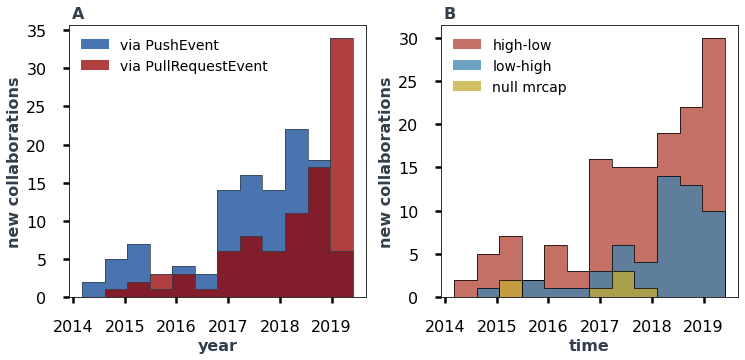

In [189]:
from notebooks_functions import *
### Number of connection event in time per event type
git_act = pd.read_pickle('export/git_data_pushpull_v4(vol1e5).pkl')
mrcap = pd.read_pickle('export/df_mrcap.pkl').drop('year',axis=1)
couples = pd.read_pickle('conn_couples.pkl')
couples = couples[couples.coll_begins>mrcap.index.min()]
eventstypes = []
for i, coupling in couples.iterrows():
    git_tmp = git_act[(git_act.sym==coupling.org_latterPP)&(git_act.actor_login==coupling.actors)&(git_act.date==coupling.coll_begins)]
    if len(git_tmp)>0:
        eventstypes.append(git_tmp['type'].iloc[0])
    else:
        print(coupling[['org1','org2','org_former','org_latter','coll_begins']])
couples['eventType'] = eventstypes

### Distribution of connection in time by high-low mrcap connection and low-high mrcap connection
import datetime
import random

hi_cryptos = []
lo_cryptos = []
for i,couple in couples.iterrows():
    org1_cap = mrcap.loc[:couple.coll_begins][couple.org1].mean()
    org2_cap = mrcap.loc[:couple.coll_begins][couple.org2].mean()
    if np.isnan(org1_cap):
        org1_cap = 0
    if np.isnan(org2_cap):
        org2_cap = 0        
    if org1_cap>org2_cap:
        hi_cryptos.append(couple.org1)
        lo_cryptos.append(couple.org2)
    elif org1_cap<org2_cap:
        hi_cryptos.append(couple.org2)
        lo_cryptos.append(couple.org1)
    else:
        hi_cryptos.append(couple.org2+'_'+couple.org1)
        lo_cryptos.append(couple.org1+'_'+couple.org2)
#         print(str(org1_cap)+' - '+str(org2_cap))
couples['high_cap'] = hi_cryptos
couples['low_cap'] = lo_cryptos
hi_lo = []
for i,couple in couples.iterrows():
    if couple.high_cap == couple.org_formerPP:
        hi_lo.append(1)
    elif couple.low_cap == couple.org_formerPP:
        hi_lo.append(0)
    else:
        hi_lo.append(2)       
couples['hi_lo_connection'] = hi_lo


## Begin figure
fig, ax = plt.subplots(figsize=(12,5))

ax1 = plt.subplot(121)
couples[couples.eventType=='PushEvent'].coll_begins.hist(ax=ax1, density=False,alpha=0.75,bins=12,range=(couples.coll_begins.min(),couples.coll_begins.max()),color='#0C4694',label='via PushEvent',zorder=3)
couples[couples.eventType=='PullRequestEvent'].coll_begins.hist(ax=ax1, density=False,alpha=0.75,bins=12,range=(couples.coll_begins.min(),couples.coll_begins.max()),color='#960000',label='via PullRequestEvent',zorder=3)
couples[couples.eventType=='PushEvent'].coll_begins.hist(ax=ax1, density=False,alpha=0.75,bins=12,range=(couples.coll_begins.min(),couples.coll_begins.max()),color='#333F4B',zorder=3,histtype='step')
couples[couples.eventType=='PullRequestEvent'].coll_begins.hist(ax=ax1, density=False,alpha=0.75,bins=12,range=(couples.coll_begins.min(),couples.coll_begins.max()),color='#333F4B',zorder=3,histtype='step')
ax1.set_xlabel('year',fontsize=f_size+2, fontweight='black',color = '#333F4B')
ax1.set_ylabel('new collaborations',fontsize=f_size+2, fontweight='black',color = '#333F4B')
ax1.legend(fontsize=f_size)
ax1.grid(alpha=.0)



ax2 = plt.subplot(122)
couples[couples.hi_lo_connection==1].coll_begins.hist(ax=ax2, alpha=0.75, color='#B04030', label='high-low', zorder=3,bins=12, range=(couples.coll_begins.min(),couples.coll_begins.max()))
couples[couples.hi_lo_connection==0].coll_begins.hist(ax=ax2, alpha=0.75, color='#3E83AF', label='low-high', zorder=3,bins=12, range=(couples.coll_begins.min(),couples.coll_begins.max()))
couples[couples.hi_lo_connection==2].coll_begins.hist(ax=ax2, alpha=0.75, color='#C4AB33', label='null mrcap', zorder=3,bins=12, range=(couples.coll_begins.min(),couples.coll_begins.max()))

# to make the black stepped hist
couples[couples.hi_lo_connection==1].coll_begins.hist(ax=ax2, alpha=0.75, histtype='step', color='k', zorder=3,bins=12, range=(couples.coll_begins.min(),couples.coll_begins.max()))
couples[couples.hi_lo_connection==0].coll_begins.hist(ax=ax2, alpha=0.75, histtype='step', color='k', zorder=3,bins=12, range=(couples.coll_begins.min(),couples.coll_begins.max()))
couples[couples.hi_lo_connection==2].coll_begins.hist(ax=ax2, alpha=0.75, histtype='step', color='k', zorder=3,bins=12, range=(couples.coll_begins.min(),couples.coll_begins.max()))


ax2.legend(fontsize=f_size)
ax2.set_xlabel('time',fontsize=f_size+2, weight='black',color='#333F4B')
ax2.set_ylabel('new collaborations',fontsize=f_size+2, weight='black',color='#333F4B')
ax2.grid(alpha=.0)


ax1.text(0.01,1.025,'A',fontsize=f_size+2, transform=ax1.transAxes, weight='black',color='#333F4B')
ax2.text(0.01,1.025,'B',fontsize=f_size+2, transform=ax2.transAxes, weight='black',color='#333F4B')

# print('Hi-Lo: {}%'.format(round(len(couples[couples.hi_lo_connection==1])/len(couples)*100)))
# print('Lo-Hi: {}%'.format(round(len(couples[couples.hi_lo_connection==0])/len(couples)*100)))
# print('Both null: {}%'.format(round(len(couples[couples.hi_lo_connection==2])/len(couples)*100)))

plt.subplots_adjust(wspace=0.25)
plt.savefig('figures/S5_rebuttal.pdf')

## Supplementary Information: Figure S6

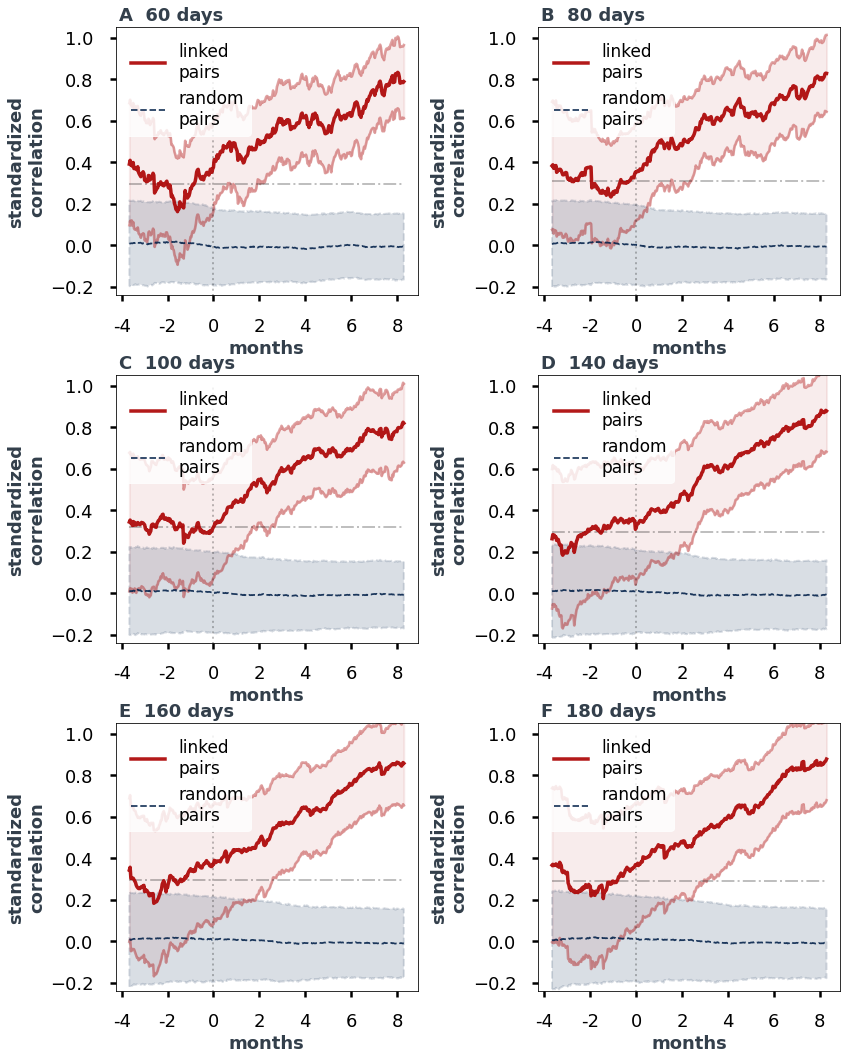

In [190]:
###### Run before  FIGURE 3
fraction = 0.15  # discard timeseries values if a fraction of less than "fraction" has non nan value at a step
slide = 1                 # number of days we are sliding for
f_size = 18      # font size
min_index = -110
max_index = 250
size=16
lwavg = 3.5
lwkde = 3
size_diff = 1.75
panel = ['A','B','C','D','E','F','G','H']
measures = ['retur'] # ['volum','volumret','mrcap','mrret','price','volat']
windows = [60,80,100,140,160,180]
sample_number = 10000
n_sem = 2
# mean '_N'-> median '_M'


###### FIGURE SI  
### Figure generation
confidence = 0.95
cut=0.5
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
fig, ax = plt.subplots(figsize=(12,15))
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
k = 1
for measure in measures:
    for win in windows:
        sCC = pd.read_pickle(f'export/sCC_summary_{measure}_{sample_number}_win{win}.pkl')
        sCC = sCC.loc[(sCC.active_cryptos/max(sCC.active_cryptos)>fraction)&(sCC.index.days<max_index)&(sCC.index.days>=min_index)]
        sRT = pd.read_pickle(f'export/sRT_summary_{measure}_{sample_number}_win{win}.pkl')
        sRT = sRT.loc[sCC.index]


        ax1 = plt.subplot(int(np.ceil(len(windows)*(len(measures))/2)),2,k)
        ax1.plot((sCC.index.days*slide)/30,sCC['avg_N'],linewidth=lwavg,alpha=.9, color='#AB0000', zorder=5,label='linked\npairs')
        conf1 = 2*sCC['sem_N'].values
        ax1.fill_between((sCC.index.days*slide)/30,sCC.avg_N+n_sem*sCC.sem_N,sCC.avg_N-n_sem*sCC.sem_N, # standard deviation of the mean
                         color='#AB0000', linewidth=2, zorder=2, alpha=0.075)#, label = '2 std  error')
        ax1.plot((sCC.index.days*slide)/30,sCC.avg_N+n_sem*sCC.sem_N,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')
        ax1.plot((sCC.index.days*slide)/30,sCC.avg_N-n_sem*sCC.sem_N,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')

        ax1.plot(sRT.index.days*slide/30,sRT['avg_N'],linestyle='--',linewidth=lwavg-size_diff,
                alpha=.9, color='#06244C', zorder=5, label='random\npairs')
        confRT1 = 2*sRT['sem_N'].values
        ax1.fill_between((sRT.index.days*slide)/30,sRT.avg_N+n_sem*sRT.sem_N,sRT.avg_N-n_sem*sRT.sem_N,linestyle='--', # standard error of the mean
                         color='#06244C', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
        ax1.plot((sRT.index.days*slide)/30,sRT.avg_N+n_sem*sRT.sem_N,color='#06244C', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ax1.plot((sRT.index.days*slide)/30,sRT.avg_N-n_sem*sRT,color='#06244C', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)

        ax1.plot((min((sCC.index.days*slide)/30),max((sCC.index.days*slide)/30)),
                    (sCC.loc['-105 days':'-1 days'].avg_N.mean(),sCC.loc['-105 days':'-1 days'].avg_N.mean()),
                    '-.',color='k',alpha=0.25)#,label = 'connected average\nbefore')
        ax1.plot((0,0),(-.5,1.),':',color='k',alpha=0.25)#, label='connection \ntime')


        ax1.set_ylim((-0.24,1.05))
        ax1.set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
        ax1.set_ylabel('standardized\ncorrelation', fontsize = f_size,fontweight='black',color = '#333F4B')
        ax1.set_xticks([-4,-2,0,2,4,6,8])
        ax1.set_xticklabels([-4,-2,0,2,4,6,8])
        ax1.tick_params('both',labelsize=f_size)
        ax1.tick_params(axis='x', colors='#000000')
        ax1.text(0.01,1.025,f'{panel[k-1]}  {win} days',fontsize=f_size, transform=ax1.transAxes, weight='black',color='#333F4B')

        ax1.legend(fontsize = f_size-1,frameon=True, loc=2, edgecolor='#FFFFFF')

        k+=1
#### ################################################################################################

plt.tight_layout()
fig.subplots_adjust(wspace=.4,hspace=0.3)
plt.savefig('figures/S6_rebuttal.pdf')

## Supplementary Information: Figure S6

Window size 40
wel 0.011909225396099636
med 0.010216909342468723
man 0.0014818250989939643
k-s 0.0011199160554912794
kru 0.002963574418644846
0.3957605993460294
Window size 60
wel 0.009706700142448847
med 0.018886618975010806
man 0.00113059704302007
k-s 0.0011154855262163652
kru 0.00226113612961946
0.3942413199356802
Window size 80
wel 0.015549594505517478
med 0.014912986406258235
man 0.002303328532383571
k-s 0.007139139358514439
kru 0.004606547800524599
0.39349464540737344
Window size 100
wel 0.025664696555815495
med 0.032976650276302304
man 0.007509579750809019
k-s 0.01514359636884859
kru 0.015018849572022245
0.39275637632995297
Window size 120
wel 0.01978209507433292
med 0.1749014202049856
man 0.010188349217669868
k-s 0.012788480839461875
kru 0.02037629916033795
0.39275637632995297
Window size 140
wel 0.011934357022517533
med 0.08112515513024329
man 0.008974381368061354
k-s 0.02771751198127212
kru 0.017948408277764477
0.39275637632995297
Window size 160
wel 0.008975444385501971
med 

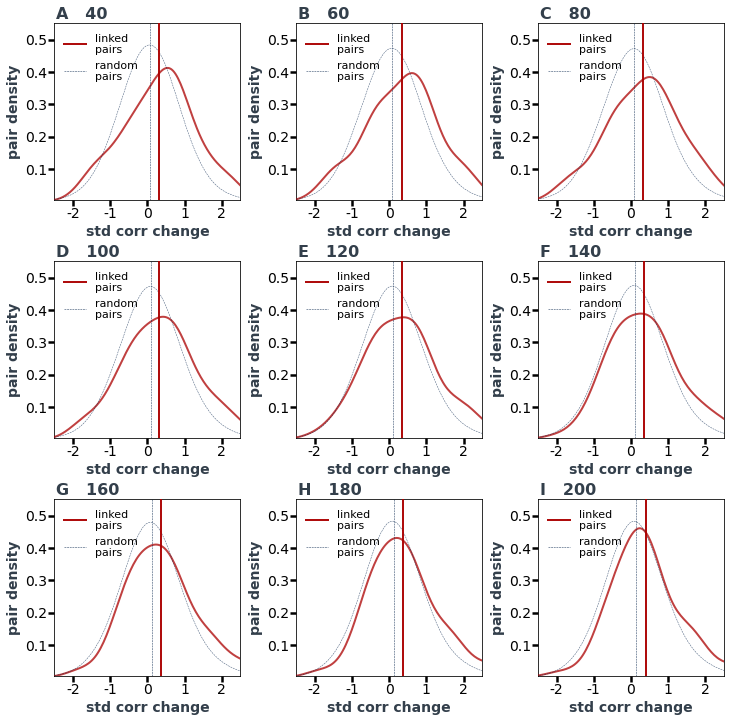

In [192]:
measure = 'retur'
corr_couples = pd.read_pickle(f'export/robustness/rp_{measure}_win{120}.pkl')
sample_time = pd.read_pickle(f'export/robustness/rpRT_{measure}_win{120}.pkl')
corr_couples.index = corr_couples.index.days
sample_time.index = sample_time.index.days

def new_dist(window_size):

    bounds = (-2.51,2.51)
    slide=1
    transient_length = 75 # 75 # ~ life della transizione secondo il modello
    # select the correlation before and after the connection time for the sample_time dataframe
    sample = sample_time.loc[-int(window_size/slide):-1]
    sample = sample.mean().reset_index().rename(columns={'index':'name',0:'before'})
    sample['after'] = sample_time.loc[int(transient_length/slide):int(transient_length/slide)+int(window_size/slide)].mean().values
    sample = sample.dropna()
    sample.reset_index(drop=True)
    # select the correlation before and after the connection time for the collaborative cryptocurrencies
    couples = corr_couples.loc[-int(window_size/slide):-1]
    couples = couples.mean().reset_index().rename(columns={'index':'name',0:'before'})
    couples['after'] = corr_couples.loc[int(transient_length/slide):int(transient_length/slide)+int(window_size/slide)].mean().values
    couples = couples.dropna()
    couples.reset_index(drop=True,inplace=True)
    df = couples.copy() # required in following cells (3 below)
    df.reset_index(drop=True,inplace=True)
    couple_distance = (couples.after-couples.before)
    sample_distance = (sample.after-sample.before)
    
    return couple_distance,sample_distance

#### ################################################################################################
rmin = -5.
rmax = 5.5
size= 14
f_size = 14
p_ind = 250
lwavg = 3
lwkde = 2
cols = 3
log = False 
x_symlog = False
fig, ax = plt.subplots(figsize=(12,12))

winds = [40,60,80,100,120,140,160,180,200]
panels = ['A','B','C','D','E','F','G','H','I']
for i in range(len(panels)):
    window_size = winds[i]
    couple_distance, sample_distance = new_dist(window_size)
    axx = plt.subplot(int(len(panels)/3),3,i+1)
    tune_bw = stats.gaussian_kde(couple_distance).covariance_factor()+0.
    couple_distance.plot.kde(ax=axx, ind=p_ind, linestyle='-', color='#AB0000', linewidth=lwkde, alpha=0.75,zorder=4,
            bw_method=tune_bw, label='_nolegend_')
    sample_distance.plot.kde(ax=axx, ind=p_ind, linestyle='--', color='#06244C',linewidth=lwkde-1.5, alpha=0.75,zorder=4,
            bw_method=tune_bw, label='_nolegend_')
    axx.axvline(couple_distance.mean(), linestyle='-',color='#AB0000',alpha=0.95,zorder=5, linewidth=lwkde,label = 'linked\npairs')
    axx.axvline(sample_distance.mean(), linestyle='--',color='#06244C',alpha=0.95,zorder=5, linewidth=lwkde-1.5,label = 'random\npairs')

#     axx.grid(True,alpha=0.35)
    axx.tick_params('both',labelsize=f_size, pad=1)
    axx.set_xlim((-2.5,2.5))
    axx.set_ylim((.005,.55))
    axx.set_ylabel('pair density',fontsize=size,fontweight='black',color = '#333F4B')
    axx.set_xlabel('std corr change',fontsize=size,fontweight='black',color = '#333F4B')
    if log:
        axx.set_yscale('log')
    if x_symlog:
        axx.set_xscale('symlog', linthreshy=0.05)
    axx.legend(fontsize=f_size-3,loc=2)
    axx.text(0.01,1.025,f'{panels[i]}   {window_size}',fontsize=f_size+2, transform=axx.transAxes, weight='black',color='#333F4B')
    axx.set_xticks([-2,-1,0,1,2])
    axx.set_xticklabels([-2,-1,0,1,2])
    print(f'Window size {window_size}')
    print('wel',stats.ttest_ind(couple_distance,sample_distance,equal_var=False,nan_policy='omit')[1])
    print('med',stats.median_test(couple_distance,sample_distance)[1])
    print('man',stats.mannwhitneyu(couple_distance,sample_distance)[1])
    print('k-s',stats.ks_2samp(couple_distance,sample_distance)[1])
    print('kru',stats.kruskal(couple_distance,sample_distance)[1])
#     print(t_ks_wilcox_double_one_samples(couple_distance,sample_distance,wilc=True,bootstrap=100))
    print(tune_bw)
    
fig.subplots_adjust(wspace=.3,hspace=0.35)
plt.savefig(f'figures/S6_rebuttal.pdf', margins='tight')

## Supplementary Information: Figure S7

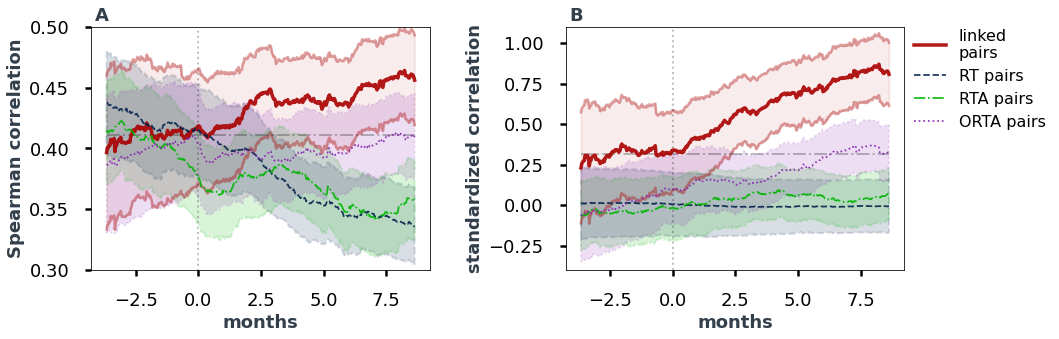

In [193]:
######  FIGURE: randomization and non standard correlation
fraction = 0.15  # discard timeseries values if a fraction of less than "fraction" has non nan value at a step
slide = 1                 # number of days we are sliding for
f_size = 18      # font size
min_index = -110
max_index = 110+150
size=16
lwavg = 3.5
lwkde = 3
size_diff = 1.75
panel = ['A','B','C','D','E','F','G','H','I']
sample_number = 10000
measures = ['retur'] # ['volum','volumret','mrcap','mrret','price','volat']
windows = [120] # [60,80,100,140,160,180]
n_sem = 2
###### FIGURE SI  
### Figure generation
confidence = 0.95
cut=0.5
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
fig, ax = plt.subplots(figsize=(15,5))
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
k = 1 
for measure in measures:
    for win in windows:
        CC = pd.read_pickle(f'export/CC_summary_{measure}_{sample_number}_win{win}.pkl')
        CC = CC.loc[(CC.active_cryptos/max(CC.active_cryptos)>fraction)&(CC.index.days<max_index)&(CC.index.days>=min_index)]
        RT = pd.read_pickle(f'export/RT_summary_{measure}_{sample_number}_win{win}.pkl')
        RT = RT.loc[CC.index]
        RTA = pd.read_pickle(f'export/RTA_summary_{measure}_{sample_number}_win{win}.pkl')
        RTA = RTA.loc[CC.index]
        ORTA = pd.read_pickle(f'export/ORTA_summary_{measure}_{sample_number}_win{win}.pkl')
        ORTA = ORTA.loc[CC.index]


        ### LP
        ax2 = plt.subplot(int(np.ceil(len(windows)*(len(measures))/2)),2,k)
        ax2.plot((CC.index.days*slide)/30,CC['avg_N'],linewidth=lwavg,alpha=.9, color='#AB0000', zorder=5,label='linked\npairs')
        conf1 = n_sem*CC['sem_N'].values
        ax2.fill_between((CC.index.days*slide)/30,CC['avg_N']+conf1,CC['avg_N']-conf1, # standard error of the mean
                         color='#AB0000', linewidth=2, zorder=2, alpha=0.075)#, label = '2 std  error')
        ax2.plot((CC.index.days*slide)/30,CC['avg_N'].values+conf1,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')
        ax2.plot((CC.index.days*slide)/30,CC['avg_N'].values-conf1,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')
        ###
        ### RT
        ax2.plot(RT.index.days*slide/30,RT['avg_N'],linestyle='--',linewidth=lwavg-size_diff,
                alpha=.9, color='#06244C', zorder=5, label='RT pairs')
        confRT1 = n_sem*RT['sem_N'].values
        ax2.fill_between((RT.index.days*slide)/30,RT['avg_N']+confRT1,RT['avg_N']-confRT1,linestyle='--', # standard error of the mean
                         color='#06244C', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
        ax2.plot((RT.index.days*slide)/30,RT['avg_N'].values+confRT1,color='#06244C', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ax2.plot((RT.index.days*slide)/30,RT['avg_N'].values-confRT1,color='#06244C', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ###
        ### RTA
        ax2.plot(RTA.index.days*slide/30,RTA['avg_N'],linestyle='-.',linewidth=lwavg-size_diff,
                 alpha=.9, color='#00B602', zorder=5, label='RTA pairs')
        confRTA1 = n_sem*RTA['sem_N'].values
        ax2.fill_between((RTA.index.days*slide)/30,RTA['avg_N']+confRTA1,RTA['avg_N']-confRTA1,linestyle='-.', # standard error of the mean
                         color='#00B602', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
        ax2.plot((RTA.index.days*slide)/30,RTA['avg_N'].values+confRTA1,color='#00B602', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ax2.plot((RTA.index.days*slide)/30,RTA['avg_N'].values-confRTA1,color='#00B602', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ###
        ### ORTA
        ax2.plot(ORTA.index.days*slide/30,ORTA['avg_N'],linestyle=':',linewidth=lwavg-size_diff,
                 alpha=.9, color='#8722B0', zorder=5, label='ORTA pairs')
        confORTA1 = n_sem*ORTA['sem_N'].values
        ax2.fill_between((ORTA.index.days*slide)/30,ORTA['avg_N']+confORTA1,ORTA['avg_N']-confORTA1,linestyle=':', # standard error of the mean
                         color='#8722B0', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
        ax2.plot((ORTA.index.days*slide)/30,ORTA['avg_N'].values+confORTA1,color='#8722B0', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ax2.plot((ORTA.index.days*slide)/30,ORTA['avg_N'].values-confORTA1,color='#8722B0', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ###
        ax2.plot((min((CC.index.days*slide)/30),max((CC.index.days*slide)/30)),
                    (CC.loc[:'-1 days'].avg.mean(),CC.loc[:'-1 days'].avg.mean()),
                    '-.',color='k',alpha=0.25)#,label = 'connected average\nbefore')
        ax2.plot((0,0),(-.5,1.),':',color='k',alpha=0.25)#, label='connection \ntime')


        ax2.set_ylim((0.3,0.5))
        ax2.set_xlabel('months', fontsize = f_size, fontweight='black',color = '#333F4B')
        ax2.set_ylabel('Spearman correlation', fontsize = f_size,fontweight='black',color = '#333F4B')
        ax2.tick_params('both',labelsize=f_size)
        ax2.tick_params(axis='x', colors='#000000')

#         ax2.legend(fontsize = f_size-2,frameon=True,loc=2)
        ax2.text(0.01,1.025,f'{panel[k-1]}',fontsize=f_size, transform=ax2.transAxes, weight='black',color='#333F4B')
########################################################################################################
        
        sCC = pd.read_pickle(f'export/sCC_summary_{measure}_{sample_number}_win{win}.pkl')
        sCC = sCC.loc[(sCC.active_cryptos/max(sCC.active_cryptos)>fraction)&(sCC.index.days<max_index)&(sCC.index.days>=min_index)]
        sRT = pd.read_pickle(f'export/sRT_summary_{measure}_{sample_number}_win{win}.pkl')
        sRT = sRT.loc[sCC.index]
        sRTA = pd.read_pickle(f'export/sRTA_summary_{measure}_{sample_number}_win{win}.pkl')
        sRTA = sRTA.loc[sCC.index]
        sORTA = pd.read_pickle(f'export/sORTA_summary_{measure}_{sample_number}_win{win}.pkl')
        sORTA = sORTA.loc[sCC.index]


        ### LP
        ax1 = plt.subplot(int(np.ceil(len(windows)*(len(measures))/2)),2,k+1)
        ax1.plot((sCC.index.days*slide)/30,sCC['avg_N'],linewidth=lwavg,alpha=.9, color='#AB0000', zorder=5,label='linked\npairs')
        conf1 = n_sem*sCC['sem_N'].values
        ax1.fill_between((sCC.index.days*slide)/30,sCC['avg_N']+conf1,sCC['avg_N']-conf1, # standard error of the mean
                         color='#AB0000', linewidth=2, zorder=2, alpha=0.075)#, label = '2 std  error')
        ax1.plot((sCC.index.days*slide)/30,sCC['avg_N'].values+conf1,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')
        ax1.plot((sCC.index.days*slide)/30,sCC['avg_N'].values-conf1,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')
        ###
        ### RT
        ax1.plot(sRT.index.days*slide/30,sRT['avg_N'],linestyle='--',linewidth=lwavg-size_diff,
                alpha=.9, color='#06244C', zorder=5, label='RT pairs')
        confRT1 = n_sem*sRT['sem_N'].values
        ax1.fill_between((sRT.index.days*slide)/30,sRT['avg_N']+confRT1,sRT['avg_N']-confRT1,linestyle='--', # standard error of the mean
                         color='#06244C', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
        ax1.plot((sRT.index.days*slide)/30,sRT['avg_N'].values+confRT1,color='#06244C', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ax1.plot((sRT.index.days*slide)/30,sRT['avg_N'].values-confRT1,color='#06244C', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ###
        ### RTA
        ax1.plot(sRTA.index.days*slide/30,sRTA['avg_N'],linestyle='-.',linewidth=lwavg-size_diff,
                 alpha=.9, color='#00B602', zorder=5, label='RTA pairs')
        confRTA1 = n_sem*sRTA['sem_N'].values
        ax1.fill_between((sRTA.index.days*slide)/30,sRTA['avg_N']+confRTA1,sRTA['avg_N']-confRTA1,linestyle='-.', # standard error of the mean
                         color='#00B602', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
        ax1.plot((sRTA.index.days*slide)/30,sRTA['avg_N'].values+confRTA1,color='#00B602', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ax1.plot((sRTA.index.days*slide)/30,sRTA['avg_N'].values-confRTA1,color='#00B602', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ###
        ### ORTA
        ax1.plot(sORTA.index.days*slide/30,sORTA['avg_N'],linestyle=':',linewidth=lwavg-size_diff,
                 alpha=.9, color='#8722B0', zorder=5, label='ORTA pairs')
        confORTA1 = n_sem*sORTA['sem_N'].values
        ax1.fill_between((sORTA.index.days*slide)/30,sORTA['avg_N']+confORTA1,sORTA['avg_N']-confORTA1,linestyle=':', # standard error of the mean
                         color='#8722B0', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
        ax1.plot((sORTA.index.days*slide)/30,sORTA['avg_N'].values+confORTA1,color='#8722B0', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ax1.plot((sORTA.index.days*slide)/30,sORTA['avg_N'].values-confORTA1,color='#8722B0', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ###
        ax1.plot((min((sCC.index.days*slide)/30),max((sCC.index.days*slide)/30)),
                    (sCC.loc[:'-1 days'].avg.mean(),sCC.loc[:'-1 days'].avg.mean()),
                    '-.',color='k',alpha=0.25)#,label = 'connected average\nbefore')
        ax1.plot((0,0),(-.5,1.2),':',color='k',alpha=0.25)#, label='connection \ntime')


        ax1.set_ylim((-0.4,1.1))
        ax1.set_xlabel('months', fontsize = f_size, fontweight='black',color = '#333F4B')
        ax1.set_ylabel('standardized correlation', fontsize = f_size,fontweight='black',color = '#333F4B')
        ax1.tick_params('both',labelsize=f_size)
        ax1.tick_params(axis='x', colors='#000000')

        ax1.legend(fontsize = f_size-2,frameon=True,loc=(1.01,0.55) , edgecolor='#FFFFFF')
        ax1.text(0.01,1.025,f'{panel[k]}',fontsize=f_size, transform=ax1.transAxes, weight='black',color='#333F4B')

        k+=1
#### ################################################################################################



plt.tight_layout()
fig.subplots_adjust(wspace=.4,hspace=0.3)
plt.savefig('figures/S7_rebuttal.pdf')

## Supplementary Information: Figure S8

In [194]:
fraction = 0.05  # discard timeseries values if a fraction of less than "fraction" has non nan value at a step
slide = 1                 # number of days we are sliding for
f_size = 18      # font size
min_index = -105
max_index = 91+150
measure = 'retur'

cc = pd.read_pickle(f'conn_couples.pkl')
CC = pd.read_pickle(f'export/robustness/rp_{measure}_win120.pkl')
CC = CC.loc[(CC.count(axis=1)/204>fraction)&(CC.index.days<max_index)&(CC.index.days>=min_index)]
CC.index = CC.index.days
sRT = pd.read_pickle(f'export/robustness/rpRT_{measure}_win120.pkl')
sRT.index = sRT.index.days
sRT = sRT.loc[CC.index]
RT = pd.read_pickle(f'export/sRT_summary_{measure}_10000_win120.pkl')
RT.index = RT.index.days
RT = RT.loc[CC.index]


def new_dist(window_size,corr_couples,sample_time):
    slide=1
    transient_length = 75
    sample = sample_time.loc[-int(window_size/slide):-1]
    sample = sample.mean().reset_index().rename(columns={'index':'name',0:'before'})
    sample['after'] = sample_time.loc[int(transient_length/slide):int(transient_length/slide)+int(window_size/slide)].mean().values
    sample = sample.dropna()
    sample.reset_index(drop=True,inplace=True)
    couples = corr_couples.loc[-int(window_size/slide):-1]
    couples = couples.mean().reset_index().rename(columns={'index':'name',0:'before'})
    couples['after'] = corr_couples.loc[int(transient_length/slide):int(transient_length/slide)+int(window_size/slide)].mean().values
    couples = couples.dropna()
    couples.reset_index(drop=True,inplace=True)
    df = couples.copy() # required in following cells (3 below)
    df.reset_index(drop=True,inplace=True)
    couple_distance = (couples.after-couples.before)
    sample_distance = (sample.after-sample.before)
    return couple_distance,sample_distance

wel 0.06753634973797115
med 0.44885531249271593
man 0.0625031471180626
k-s 0.4834236218174984
kru 0.1250039356648884


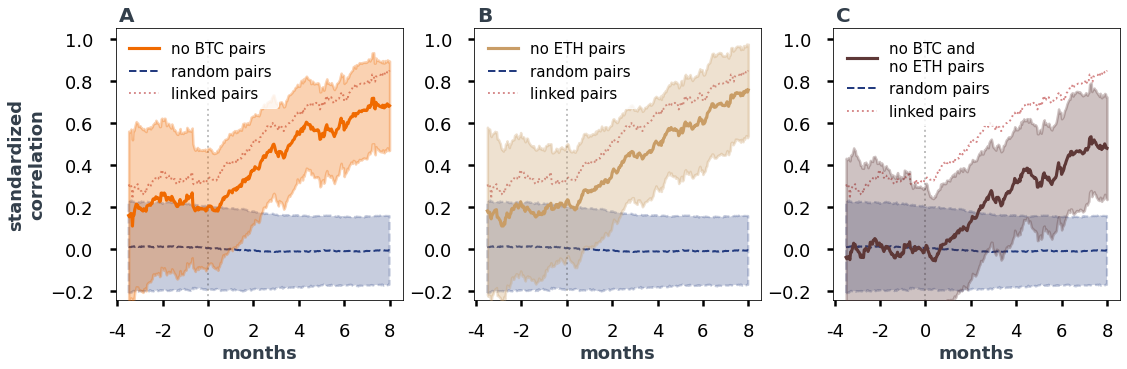

In [196]:
cb = '#233B7F'
cp = '#AA0E0F'
cbtc = '#f06a00'
ceth = '#c99d66'
cboth = '#5E3837'

n_sem = 2
lwavg=2.5
alha_fill = 0.3
alpha_border_fill = 0.25

fig, ax = plt.subplots(1,3,figsize=(18,5))


exclude_coin1 = 'BTC'
CCBTC = CC[cc[(cc.org1!=exclude_coin1)&(cc.org2!=exclude_coin1)].index]
ax[0].plot(CCBTC.index/30,CCBTC.mean(axis=1),label='no BTC pairs', color=cbtc, zorder=5, linestyle = '-', linewidth=lwavg+lwavg/4)
ax[0].fill_between(CCBTC.index/30,CCBTC.mean(axis=1)+n_sem*CCBTC.sem(axis=1),CCBTC.mean(axis=1)-n_sem*CCBTC.sem(axis=1),alpha=alha_fill, linewidth=lwavg, color=cbtc, zorder=5)

exclude_coin2 = 'ETH'
CCETH = CC[cc[(cc.org1!=exclude_coin2)&(cc.org2!=exclude_coin2)].index]
ax[1].plot(CCETH.index/30,CCETH.mean(axis=1),label='no ETH pairs', color=ceth, zorder=5, linestyle = '-', linewidth=lwavg+lwavg/4)
ax[1].fill_between(CCETH.index/30,CCETH.mean(axis=1)+n_sem*CCETH.sem(axis=1),CCETH.mean(axis=1)-n_sem*CCETH.sem(axis=1),alpha=alha_fill, linewidth=lwavg, color=ceth, zorder=5)

CCBOTH = CC[cc[(cc.org1!=exclude_coin1)&(cc.org2!=exclude_coin1)&(cc.org1!=exclude_coin2)&(cc.org2!=exclude_coin2)].index]
ax[2].plot(CCBOTH.index/30,CCBOTH.mean(axis=1),label='no BTC and\nno ETH pairs', color=cboth, zorder=5, linestyle = '-', linewidth=lwavg+lwavg/4)
ax[2].fill_between(CCBOTH.index/30,CCBOTH.mean(axis=1)+n_sem*CCBOTH.sem(axis=1),CCBOTH.mean(axis=1)-n_sem*CCBOTH.sem(axis=1),alpha=alha_fill, linewidth=lwavg, color=cboth, zorder=5)



ax[0].plot(RT.index/30,RT.avg_N,label=f'random pairs', color=cb, linestyle='--')
ax[0].fill_between(RT.index/30,RT.avg_N+n_sem*RT.sem_N,RT.avg_N-n_sem*RT.sem_N,alpha=0.25, color=cb,linewidth=lwavg-lwavg/8, linestyle='--')
ax[1].plot(RT.index/30,RT.avg_N,label=f'random pairs', color=cb, linestyle='--')
ax[1].fill_between(RT.index/30,RT.avg_N+n_sem*RT.sem_N,RT.avg_N-n_sem*RT.sem_N,alpha=0.25, color=cb,linewidth=lwavg-lwavg/8, linestyle='--')
ax[2].plot(RT.index/30,RT.avg_N,label=f'random pairs', color=cb, linestyle='--')
ax[2].fill_between(RT.index/30,RT.avg_N+n_sem*RT.sem_N,RT.avg_N-n_sem*RT.sem_N,alpha=0.25, color=cb,linewidth=lwavg-lwavg/8, linestyle='--')

ax[0].plot(CC.index/30,CC.mean(axis=1),label='linked pairs', color=cp,zorder=1, linewidth=lwavg-lwavg/4,alpha=0.5, linestyle = ':')
# ax[0].fill_between(CC.index/30,CC.mean(axis=1)+n_sem*CC.sem(axis=1),CC.mean(axis=1)-n_sem*CC.sem(axis=1),alpha=0.1,linewidth=lwavg-lwavg/4, color=cp,zorder=1)
ax[1].plot(CC.index/30,CC.mean(axis=1),label='linked pairs', color=cp,zorder=1, linewidth=lwavg-lwavg/4,alpha=0.5, linestyle = ':')
# ax[1].fill_between(CC.index/30,CC.mean(axis=1)+n_sem*CC.sem(axis=1),CC.mean(axis=1)-n_sem*CC.sem(axis=1),alpha=0.1,linewidth=lwavg-lwavg/4, color=cp,zorder=1)
ax[2].plot(CC.index/30,CC.mean(axis=1),label='linked pairs', color=cp,zorder=1, linewidth=lwavg-lwavg/4,alpha=0.5, linestyle = ':')
# ax[2].fill_between(CC.index/30,CC.mean(axis=1)+n_sem*CC.sem(axis=1),CC.mean(axis=1)-n_sem*CC.sem(axis=1),alpha=0.1,linewidth=lwavg-lwavg/4, color=cp,zorder=1)


ax[0].plot((0,0),(-.3,1.),':',color='k',alpha=0.25)#, label='connection \ntime')
ax[1].plot((0,0),(-.3,1.),':',color='k',alpha=0.25)#, label='connection \ntime')
ax[2].plot((0,0),(-.3,1.),':',color='k',alpha=0.25)#, label='connection \ntime')

ax[0].set_ylim((-0.24,1.05))
ax[0].set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
ax[0].set_ylabel('standardized\ncorrelation', fontsize = f_size,fontweight='black',color = '#333F4B')
ax[0].set_xticks([-4,-2,0,2,4,6,8])
ax[0].set_xticklabels([-4,-2,0,2,4,6,8])
ax[0].tick_params('both',labelsize=f_size)
ax[0].tick_params(axis='x', colors='#000000')
ax[0].legend(fontsize = f_size-3,frameon=True, loc=2, edgecolor='#FFFFFF');
ax[1].set_ylim((-0.24,1.05))
ax[1].set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
# ax[1].set_ylabel('standardized\ncorrelation', fontsize = f_size,fontweight='black',color = '#333F4B')
ax[1].set_xticks([-4,-2,0,2,4,6,8])
ax[1].set_xticklabels([-4,-2,0,2,4,6,8])
ax[1].tick_params('both',labelsize=f_size)
ax[1].tick_params(axis='x', colors='#000000')
ax[1].legend(fontsize = f_size-3,frameon=True, loc=2, edgecolor='#FFFFFF');
ax[2].set_ylim((-0.24,1.05))
ax[2].set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
# ax[2].set_ylabel('standardized\ncorrelation', fontsize = f_size,fontweight='black',color = '#333F4B')
ax[2].set_xticks([-4,-2,0,2,4,6,8])
ax[2].set_xticklabels([-4,-2,0,2,4,6,8])
ax[2].tick_params('both',labelsize=f_size)
ax[2].tick_params(axis='x', colors='#000000')
ax[2].legend(fontsize = f_size-3,frameon=True, loc=2, edgecolor='#FFFFFF');

ax[0].text(0.01,1.025,'A',fontsize=f_size+2, transform=ax[0].transAxes, weight='black',color='#333F4B')
ax[1].text(0.01,1.025,'B',fontsize=f_size+2, transform=ax[1].transAxes, weight='black',color='#333F4B')
ax[2].text(0.01,1.025,'C',fontsize=f_size+2, transform=ax[2].transAxes, weight='black',color='#333F4B')


couple_distance, sample_distance = new_dist(150,CCBOTH,sRT)
print('wel',stats.ttest_ind(couple_distance,sample_distance,equal_var=False,nan_policy='omit')[1])
print('med',stats.median_test(couple_distance,sample_distance)[1])
print('man',stats.mannwhitneyu(couple_distance,sample_distance)[1])
print('k-s',stats.ks_2samp(couple_distance,sample_distance)[1])
print('kru',stats.kruskal(couple_distance,sample_distance)[1])

plt.subplots_adjust(wspace=0.25)
plt.savefig('figures/S8_rebuttal.pdf')

## Supplementary Information: Figure S8bis

In [197]:
ed = pd.read_pickle('conn_couples.pkl')
# ###### 0.0 load github push/accepted-pull data
tmp1 = pd.read_pickle('export/git_data_pushpull_v4(vol1e5).pkl')
tmp1 = tmp1[tmp1.accepted]
tmp1 = tmp1[(tmp1.actor_login.notna())]
tmp1 = tmp1.reset_index(drop=True)

###### Generates EDGES dataframe with duplicates!!!
edges_list = []
group_tmp = tmp1.groupby('actor_login')
for actor in tmp1.drop_duplicates('actor_login').actor_login:
    tmp_g = group_tmp.get_group(actor)
    if len(tmp_g)>1:
        tmp_g = tmp_g.groupby(['sym', 'date']).count().reset_index()
        tmp_count = tmp_g.groupby(['sym']).count().reset_index().sort_values('sym')[['sym','type']]
        tmp_g = tmp_g.sort_values('date').drop_duplicates('sym').sort_values('sym')
        list1 = list(tmp_g.sym)
        list2 = list(tmp_g.sym)
        tmp_g = tmp_g.set_index('sym')
        tmp_count = tmp_count.set_index('sym')
        for org1 in list1:
            list2.remove(org1)
            for org2 in list2:
                if org1 != org2:
                    edges_list.append([org1,org2,tmp_count.loc[org1]['type'],tmp_count.loc[org2]['type'],
                                       actor,tmp_g.loc[[org1,org2]]['date'].max(),
                                       tmp_g.loc[[org1]]['date'].max(),tmp_g.loc[[org2]]['date'].max()])
df_edges = pd.DataFrame({'org1':[edges_list[i][0] for i in range(len(edges_list))],
                         'org2':[edges_list[i][1] for i in range(len(edges_list))],
                         'events1':[edges_list[i][2] for i in range(len(edges_list))],
                         'events2':[edges_list[i][3] for i in range(len(edges_list))],
                         'actors':[edges_list[i][4] for i in range(len(edges_list))],
                         'collaboration_begins':[edges_list[i][5] for i in range(len(edges_list))],
                         'org1_begins':[edges_list[i][6] for i in range(len(edges_list))],
                         'org2_begins':[edges_list[i][7] for i in range(len(edges_list))]})


df_edges['pairs'] = df_edges[['org1','org2']].apply(lambda x: sorted([x.org1,x.org2]),axis=1)
dfe = df_edges.groupby(['org1','org2']).actors.apply(list).reset_index()
dfe['count_actors'] = df_edges.groupby(['org1','org2']).count().reset_index().actors
dfe = dfe.merge(ed[['org1','org2']],on=['org1','org2'],how='inner')

wel 0.01851069404137676
med 0.23987298885112593
man 0.007218545242001412
k-s 0.010169686204099783
kru 0.014436763316042671


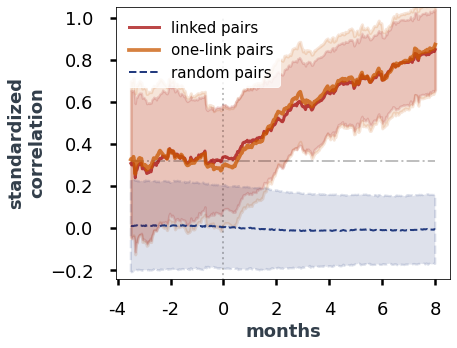

In [198]:
cb = '#233B7F'
cp = '#A60B0B'
cone = '#C95700'
cmore = '#EA7741'
n_sem = 2
lwavg=3

fig, ax = plt.subplots(figsize=(6,5))

plt.plot(CC.index/30,CC.mean(axis=1),label='linked pairs', color=cp,zorder=5, linewidth=lwavg,alpha=0.75)
plt.fill_between(CC.index/30,CC.mean(axis=1)+n_sem*CC.sem(axis=1),CC.mean(axis=1)-n_sem*CC.sem(axis=1),alpha=0.15,linewidth=lwavg-lwavg/4, color=cp,zorder=5)


CONE = CC[dfe[dfe.count_actors==1].index]
plt.plot(CONE.index/30,CONE.mean(axis=1),label=f'one-link pairs',color=cone, linewidth=lwavg+lwavg/4, zorder=5, alpha=0.75)
plt.fill_between(CONE.index/30,CONE.mean(axis=1)+n_sem*CONE.sem(axis=1),CONE.mean(axis=1)-n_sem*CONE.sem(axis=1),linewidth=lwavg,alpha=0.15, color=cone)


plt.plot(RT.index/30,RT.avg_N,label=f'random pairs', color=cb, linestyle='--')
plt.fill_between(RT.index/30,RT.avg_N+n_sem*RT.sem_N,RT.avg_N-n_sem*RT.sem_N,alpha=0.15, color=cb,linewidth=lwavg-lwavg/4, linestyle='--')

ax.plot((min((CC.index)/30),max((CC.index)/30)),
            (CC.loc[:-1].mean(axis=1).mean(),CC.loc[:-1].mean(axis=1).mean()),
            '-.',color='k',alpha=0.25)#,label = 'connected average\nbefore')
ax.plot((0,0),(-.3,1.),':',color='k',alpha=0.25)#, label='connection \ntime')

ax.set_ylim((-0.24,1.05))
ax.set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
ax.set_ylabel('standardized\ncorrelation', fontsize = f_size,fontweight='black',color = '#333F4B')
ax.set_xticks([-4,-2,0,2,4,6,8])
ax.set_xticklabels([-4,-2,0,2,4,6,8])
ax.tick_params('both',labelsize=f_size)
ax.tick_params(axis='x', colors='#000000')

ax.legend(fontsize = f_size-3,frameon=True, loc=2, edgecolor='#FFFFFF');


couple_distance, sample_distance = new_dist(120,CONE,sRT)
print('wel',stats.ttest_ind(couple_distance,sample_distance,equal_var=False,nan_policy='omit')[1])
print('med',stats.median_test(couple_distance,sample_distance)[1])
print('man',stats.mannwhitneyu(couple_distance,sample_distance)[1])
print('k-s',stats.ks_2samp(couple_distance,sample_distance)[1])
print('kru',stats.kruskal(couple_distance,sample_distance)[1])

plt.savefig('figures/S8bis_rebuttal.pdf')

## Supplementary Information: Figure S9

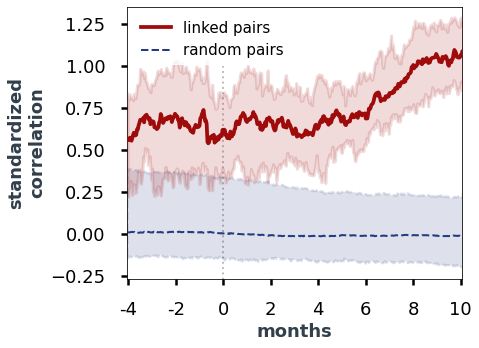

In [199]:
cb = '#233B7F'
cp = '#9F0A0A'

n_sem = 2
lwavg=3
alha_fill = 0.15
alpha_border_fill = 0.35

mCC = pd.read_pickle(f'export/sCC_summary_{measure}_10000_win120_M.pkl')
mCC.index = mCC.index.days
mRT = pd.read_pickle(f'export/sRT_summary_{measure}_10000_win120_M.pkl')
mRT.index = mRT.index.days
mCC = mCC.loc[-121:400]
mRT = mRT.loc[mCC.index]

fig, ax = plt.subplots(figsize=(6,5))

ax.plot(mCC.index/30,mCC.avg_M,label='linked pairs', color=cp, zorder=5, linestyle = '-', linewidth=lwavg+lwavg/4)
ax.fill_between(mCC.index/30,mCC.right_quant_M,mCC.left_quant_M,alpha=alha_fill, linewidth=lwavg, color=cp, zorder=5)

ax.plot(mRT.index/30,mRT.avg_N,label=f'random pairs', color=cb, linestyle='--')
ax.fill_between(mRT.index/30,mRT.right_quant_M,mRT.left_quant_M,alpha=0.15, color=cb,linewidth=lwavg-lwavg/4, linestyle='--')


ax.plot((0,0),(-.3,1.),':',color='k',alpha=0.25)#, label='connection \ntime')

ax.set_xlim((-4.05,10.05))
ax.set_ylim((-0.265,1.35))
ax.set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
ax.set_ylabel('standardized\ncorrelation', fontsize = f_size,fontweight='black',color = '#333F4B')
ax.set_xticks([-4,-2,0,2,4,6,8,10])
ax.set_xticklabels([-4,-2,0,2,4,6,8,10])
ax.tick_params('both',labelsize=f_size)
ax.tick_params(axis='x', colors='#000000')
ax.legend(fontsize = f_size-3,frameon=True, loc=2, edgecolor='#FFFFFF');


plt.savefig('figures/S9_rebuttal.pdf')

## Supplementary Information: Figure S10

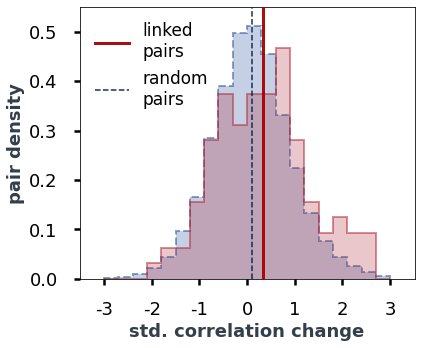

In [201]:
CC = pd.read_pickle(f'export/robustness/rp_{measure}_win120.pkl')
CC = CC.loc[(CC.count(axis=1)/204>fraction)&(CC.index.days<max_index)&(CC.index.days>=min_index)]
CC.index = CC.index.days
sRT = pd.read_pickle(f'export/robustness/rpRT_{measure}_win120.pkl')
sRT.index = sRT.index.days
sRT = sRT.loc[CC.index]

#### ################################################################################################
couple_distance, sample_distance = new_dist(120,CC,sRT)
log = False 
x_symlog = False
tune_bw = stats.gaussian_kde(couple_distance).covariance_factor()+0.
bins = 20
fig, ax3 = plt.subplots(figsize=(6,5))

### HISTOGRAMS
couple_distance.hist(ax=ax3, bins=bins,range=(-3,3), linestyle='-', color='#AF2332', linewidth=lwavg, alpha=0.25,zorder=4,
        density=True)
sample_distance.hist(ax=ax3, bins=bins,range=(-3,3), linestyle='--', color='#194795',linewidth=lwavg, alpha=0.25,zorder=3,
        density=True)
couple_distance.hist(ax=ax3, bins=bins,range=(-3,3), linestyle='-', color='#AF2332', linewidth=lwavg-1, alpha=0.5,zorder=4,
        density=True,histtype='step')
sample_distance.hist(ax=ax3, bins=bins,range=(-3,3), linestyle='--', color='#194795',linewidth=lwavg-1, alpha=0.5,zorder=3,
        density=True,histtype='step')
ax3.axvline(couple_distance.mean(), linestyle='-',color='#AB0000',alpha=0.95,zorder=5, linewidth=lwavg,label = 'linked\npairs')
ax3.axvline(sample_distance.mean(), linestyle='--',color='#06244C',alpha=0.95,zorder=5, linewidth=lwavg-1.5,label = 'random\npairs')

ax3.grid(False)
# ax3.tick_params('#491A65', labelsize=size, colors='#491A65')
ax3.tick_params('both',labelsize=f_size)
ax3.set_xlim((-3.51,3.51))
ax3.set_ylim((.00,.55))
ax3.set_ylabel('pair density',fontsize=f_size,fontweight='black',color = '#333F4B')
ax3.set_xlabel('std. correlation change',fontsize=f_size,fontweight='black',color = '#333F4B')
if log:
    ax3.set_yscale('log')
if x_symlog:
    ax3.set_xscale('symlog', linthreshy=0.05)
ax3.legend(fontsize=f_size-1, frameon=False)
ax3.set_xticks([-3,-2,-1,0,1,2,3]);
ax3.set_xticklabels([-3,-2,-1,0,1,2,3]);

plt.savefig('figures/S10_rebuttal.pdf')

## Supplementary Information: Figure S11

In [202]:
step = 1
# size of the interval before
Bsize = np.nan
# shift di after dopo il connection time
start = 0

bootstrap = 1000
points = list(range(1,200))
increasing_percentage = np.zeros(len(points))
increasing_std = np.zeros(len(points))
Rincreasing_percentage = np.zeros(len(points))
Rincreasing_std = np.zeros(len(points))

df_tmp = pd.read_pickle('export/robustness/rp_retur_win120.pkl')
df_tmp.index = df_tmp.index.days
Rdf_tmp = pd.read_pickle('export/robustness/rpRT_retur_win120.pkl')
Rdf_tmp.index = Rdf_tmp.index.days
i=0
for size in points:
    if np.isnan(Bsize):
        Bsize = size
    edges = pd.read_pickle('conn_couples.pkl').sort_values('coll_begins').reset_index(drop=True)
    before = df_tmp.loc[-int(Bsize/step):0].mean(axis=0)
    after = df_tmp.loc[int(start/step):int((start+size)/step)].mean(axis=0)
    before = before.reset_index().rename(columns={0:'before'})[['before']]
    before['org1'] = edges.org1
    before['org2'] = edges.org2
    bef_aft = before.copy()
    bef_aft['after'] = after.values

    edges = edges.merge(bef_aft, on=['org1','org2'],how='left')
    # select the dataframe with non nan before/after values
    edges = edges[(edges.before.notna())&(edges.after.notna())]
    bootstrap_size = len(edges)

    inc_candidates = np.zeros(bootstrap)
    inc_candidates[:] = np.nan
    
    for boot_run in range(bootstrap):
        tmp_pairs = edges.sample(bootstrap_size,replace=True)
        inc_candidates[boot_run] = len(tmp_pairs[(tmp_pairs.before<tmp_pairs.after)])/bootstrap_size

    increasing_percentage[i] = np.mean(inc_candidates)
    increasing_std[i] = np.std(inc_candidates)

    
    ### Random bootstrapping 
    ## Loading Random pairs and computing before after for 
    Redges = pd.read_pickle('rand_conn_time_couples.pkl').sort_values('coll_begins').reset_index(drop=True)
    Rbefore = Rdf_tmp.loc[-int(Bsize/step):0].mean(axis=0)
    Rafter = Rdf_tmp.loc[int(start/step):int((start+size)/step)].mean(axis=0)
    Rbefore = Rbefore.reset_index().rename(columns={0:'before'})[['before']]
    Rbefore['org1'] = Redges.org1
    Rbefore['org2'] = Redges.org2
    Rbef_aft = Rbefore.copy()
    Rbef_aft['after'] = Rafter.values
    Redges = Redges.merge(Rbef_aft, on=['org1','org2'],how='left')
    Redges_notna = Redges[(Redges.before.notna())&(Redges.after.notna())]

    Rinc_candidates = np.zeros(bootstrap)
    Rinc_candidates[:] = np.nan
    
    for boot_run in range(bootstrap):
        Rtmp_pairs = Redges_notna.sample(bootstrap_size,replace=True)
        Rinc_candidates[boot_run] = len(Rtmp_pairs[(Rtmp_pairs.before<Rtmp_pairs.after)])/bootstrap_size
    
    Rincreasing_percentage[i] = np.mean(Rinc_candidates)
    Rincreasing_std[i] = np.std(Rinc_candidates)
    i+=1

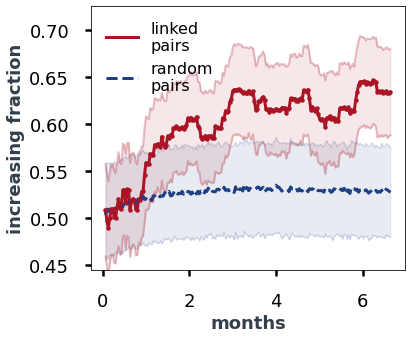

In [245]:
setup_mpl()

fig,ax = plt.subplots(figsize=(6,5))
c1 = '#1E4086'
c2 = '#AB1424'
frame = 0.0            # distance od curves from the frame
scatter_size = 20       # size of the dots
plot_size = 2           # line width of the plot
area_alpha = 0.1        # apha value for the fillbetween

### Connected couples
ax.plot(np.array(points[1:])/30,increasing_percentage[1:],lw=plot_size+1, color=c2, label='linked\npairs')
ax.plot(np.array(points[1:])/30,increasing_percentage[1:]+increasing_std[1:],lw=plot_size, color=c2,alpha=0.25)
ax.plot(np.array(points[1:])/30,increasing_percentage[1:]-increasing_std[1:],lw=plot_size, color=c2,alpha=0.25)
ax.scatter(np.array(points[1:])/30,increasing_percentage[1:],s=scatter_size, color=c2,lw = 0,edgecolors='#424242',zorder=4)
ax.fill_between(np.array(points[1:])/30,increasing_percentage[1:]+increasing_std[1:],increasing_percentage[1:]-increasing_std[1:],alpha=area_alpha, color=c2, zorder=4)

### Random with bootstrap
ax.fill_between(np.array(points[1:])/30,Rincreasing_percentage[1:]+Rincreasing_std[1:],Rincreasing_percentage[1:]-Rincreasing_std[1:],alpha=area_alpha, color=c1)
ax.plot(np.array(points[1:])/30,Rincreasing_percentage[1:]+Rincreasing_std[1:],lw=plot_size-1, color=c1,alpha=0.15)
ax.plot(np.array(points[1:])/30,Rincreasing_percentage[1:]-Rincreasing_std[1:],lw=plot_size-1, color=c1,alpha=0.15)
ax.plot(np.array(points[1:])/30,Rincreasing_percentage[1:],lw=plot_size+1, color=c1,linestyle='--', label='random\npairs')
# ax.scatter(points,Rincreasing_percentage,s=scatter_size/2, color=c1,lw = .25,edgecolors='#424242',zorder=4)

ax.set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
ax.set_ylabel('increasing fraction', fontsize = f_size,fontweight='black',color = '#333F4B')
ax.grid(alpha=frame)
ax.legend(fontsize=f_size-2)
ax.set_ylim((0.445,0.725))
ax.tick_params('both',labelsize=f_size)

plt.tight_layout()
plt.savefig('figures/S11_rebuttal.pdf')

## Supplementary Information: Figure S12

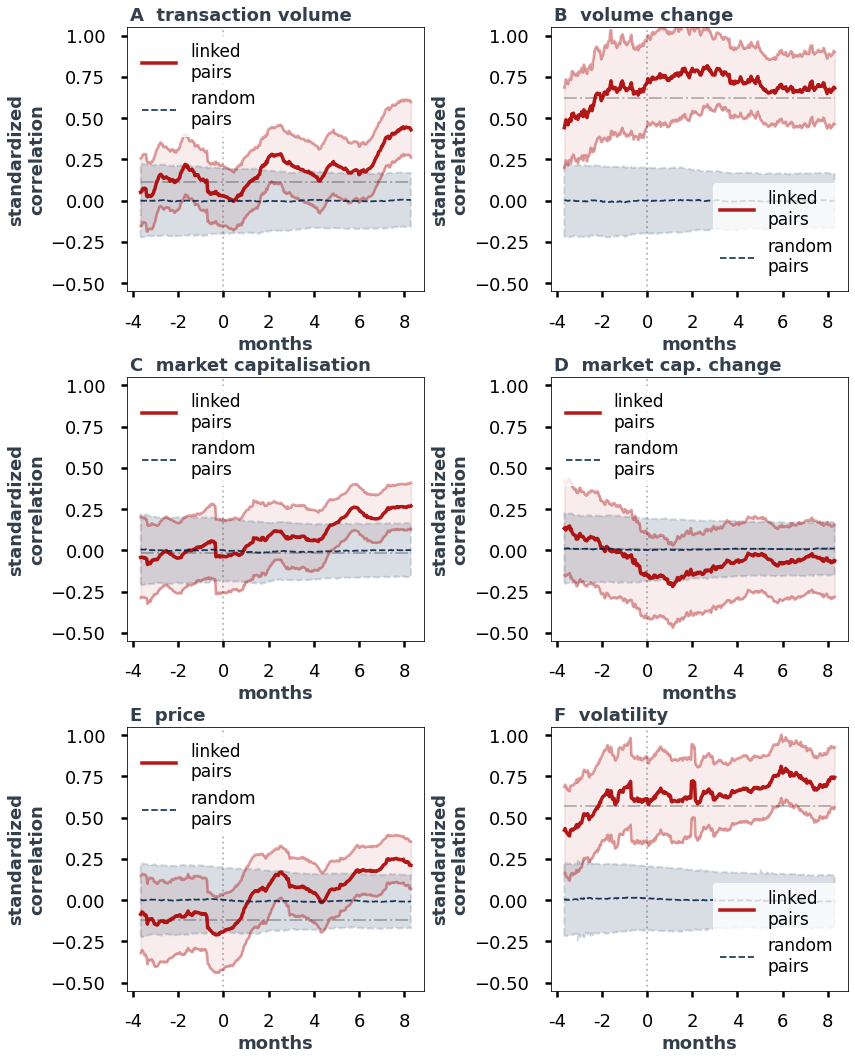

In [204]:
###### Run before  FIGURE 3
fraction = 0.15  # discard timeseries values if a fraction of less than "fraction" has non nan value at a step
slide = 1                 # number of days we are sliding for
f_size = 18      # font size
min_index = -110
max_index = 250
size=16
lwavg = 3.5
lwkde = 3
size_diff = 1.75
panel = ['A','B','C','D','E','F','G','H']
measures = ['volum','volumret','mrcap','mrret','price','volat']
measures_long = ['transaction volume','volume change','market capitalisation','market cap. change','price','volatility']
windows = [120]
sample_number = 10000
n_sem = 2
# mean '_N'-> median '_M'


###### FIGURE SI  
### Figure generation
confidence = 0.95
cut=0.5
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
fig, ax = plt.subplots(figsize=(12,15))
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 
k = 1
for measure in measures:
    for win in windows:
        sCC = pd.read_pickle(f'export/sCC_summary_{measure}_{sample_number}_win{win}.pkl')
        sCC = sCC.loc[(sCC.active_cryptos/max(sCC.active_cryptos)>fraction)&(sCC.index.days<max_index)&(sCC.index.days>=min_index)]
        sRT = pd.read_pickle(f'export/sRT_summary_{measure}_{sample_number}_win{win}.pkl')
        sRT = sRT.loc[sCC.index]


        ax1 = plt.subplot(int(np.ceil(len(windows)*(len(measures))/2)),2,k)
        ax1.plot((sCC.index.days*slide)/30,sCC['avg_N'],linewidth=lwavg,alpha=.9, color='#AB0000', zorder=5,label='linked\npairs')
        conf1 = 2*sCC['sem_N'].values
        ax1.fill_between((sCC.index.days*slide)/30,sCC.avg_N+n_sem*sCC.sem_N,sCC.avg_N-n_sem*sCC.sem_N, # standard deviation of the mean
                         color='#AB0000', linewidth=2, zorder=2, alpha=0.075)#, label = '2 std  error')
        ax1.plot((sCC.index.days*slide)/30,sCC.avg_N+n_sem*sCC.sem_N,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')
        ax1.plot((sCC.index.days*slide)/30,sCC.avg_N-n_sem*sCC.sem_N,color='#AB0000', linewidth=lwavg-lwavg/4, zorder=2, alpha=0.35)#, label = 'standard error')

        ax1.plot(sRT.index.days*slide/30,sRT['avg_N'],linestyle='--',linewidth=lwavg-size_diff,
                alpha=.9, color='#06244C', zorder=5, label='random\npairs')
        confRT1 = 2*sRT['sem_N'].values
        ax1.fill_between((sRT.index.days*slide)/30,sRT.avg_N+n_sem*sRT.sem_N,sRT.avg_N-n_sem*sRT.sem_N,linestyle='--', # standard error of the mean
                         color='#06244C', linewidth=2, zorder=2, alpha=0.15)#, label = '2 std  error')
        ax1.plot((sRT.index.days*slide)/30,sRT.avg_N+n_sem*sRT.sem_N,color='#06244C', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)
        ax1.plot((sRT.index.days*slide)/30,sRT.avg_N-n_sem*sRT,color='#06244C', linewidth=lwavg-lwavg/2-size_diff, zorder=2, alpha=0.35)

        ax1.plot((min((sCC.index.days*slide)/30),max((sCC.index.days*slide)/30)),
                    (sCC.loc['-105 days':'-1 days'].avg_N.mean(),sCC.loc['-105 days':'-1 days'].avg_N.mean()),
                    '-.',color='k',alpha=0.25)#,label = 'connected average\nbefore')
        ax1.plot((0,0),(-1,1.2),':',color='k',alpha=0.25)#, label='connection \ntime')


        ax1.set_ylim((-0.55,1.05))
        ax1.set_xlabel('months', fontsize = f_size,fontweight='black',color = '#333F4B')
        ax1.set_ylabel('standardized\ncorrelation', fontsize = f_size,fontweight='black',color = '#333F4B')
        ax1.set_xticks([-4,-2,0,2,4,6,8])
        ax1.set_xticklabels([-4,-2,0,2,4,6,8])
        ax1.tick_params('both',labelsize=f_size)
        ax1.tick_params(axis='x', colors='#000000')
        ax1.text(0.01,1.025,f'{panel[k-1]}  {measures_long[k-1]}',fontsize=f_size, transform=ax1.transAxes, weight='black',color='#333F4B')
        loc = 4 if (k==2)|(k==6) else 2
        ax1.legend(fontsize = f_size-1,frameon=True, loc=loc, edgecolor='#FFFFFF')

        k+=1
#### ################################################################################################

plt.tight_layout()
fig.subplots_adjust(wspace=.425,hspace=0.325)
plt.savefig('figures/S12_rebuttal.pdf')

## Supplementary Information: Figure S13

In [205]:
##################################################################################################################
# ETÁ delle CRYPTO ETÁ di SVILUPPO e DI MERCATO
git = pd.read_pickle('export/git_data_pushpull_v4(vol1e5).pkl')
pri = pd.read_pickle('export/df_price.pkl')

lp = pd.read_pickle('conn_couples.pkl')
rt = pd.read_pickle('rand_conn_time_couples.pkl')

f_size = 18
size = f_size-2
git_sym = git.drop_duplicates('sym',keep='first')[['sym','date']]

ages1 = lp.apply(lambda x: (x.coll_begins-pri[x.org1].first_valid_index()).days,axis=1)
ages2 = lp.apply(lambda x: (x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
agesd = lp.apply(lambda x: (np.abs(pri[x.org1].first_valid_index()-pri[x.org2].first_valid_index())).days,axis=1)

Rages1 = rt.apply(lambda x: (x.coll_begins-pri[x.org1].first_valid_index()).days,axis=1)
Rages2 = rt.apply(lambda x: (x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
Ragesd = rt.apply(lambda x: (np.abs(pri[x.org1].first_valid_index()-pri[x.org2].first_valid_index())).days,axis=1)

# Development age
developer_first_edit_age_on_first_crypto = lp.apply(lambda x: max(x.coll_begins-git[(git.sym==x.org1)&(git.actor_login==x.actors)].drop_duplicates('sym',keep='first')['date'].values[0],x.coll_begins-git[(git.sym==x.org2)&(git.actor_login==x.actors)].drop_duplicates('sym',keep='first')['date'].values[0]).days,axis=1)
developer_first_edit_age_on_second_crypto = lp.apply(lambda x: min(x.coll_begins-git[(git.sym==x.org1)&(git.actor_login==x.actors)].drop_duplicates('sym',keep='first')['date'].values[0],x.coll_begins-git[(git.sym==x.org2)&(git.actor_login==x.actors)].drop_duplicates('sym',keep='first')['date'].values[0]).days,axis=1)
## (second edited age is always zero) -> developer_first_edit_age_on_second_crypto is a list of zeros
# Project age
project_first_edit_age_on_first_crypto = lp.apply(lambda x: max(x.coll_begins-git[(git.sym==x.org1)].drop_duplicates('sym',keep='first')['date'].values[0],x.coll_begins-git[(git.sym==x.org2)].drop_duplicates('sym',keep='first')['date'].values[0]).days,axis=1)
project_first_edit_age_on_second_crypto = lp.apply(lambda x: min(x.coll_begins-git[(git.sym==x.org1)].drop_duplicates('sym',keep='first')['date'].values[0],x.coll_begins-git[(git.sym==x.org2)].drop_duplicates('sym',keep='first')['date'].values[0]).days,axis=1)
# Market age
old_market_age = lp.apply(lambda x: max(x.coll_begins-pri[x.org1].first_valid_index(),x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
new_market_age = lp.apply(lambda x: min(x.coll_begins-pri[x.org1].first_valid_index(),x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
market_agediff = np.abs(old_market_age-new_market_age)

Rold_market_age = rt.apply(lambda x: max(x.coll_begins-pri[x.org1].first_valid_index(),x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
Rnew_market_age = rt.apply(lambda x: min(x.coll_begins-pri[x.org1].first_valid_index(),x.coll_begins-pri[x.org2].first_valid_index()).days,axis=1)
Rmarket_agediff = np.abs(Rold_market_age-Rnew_market_age)

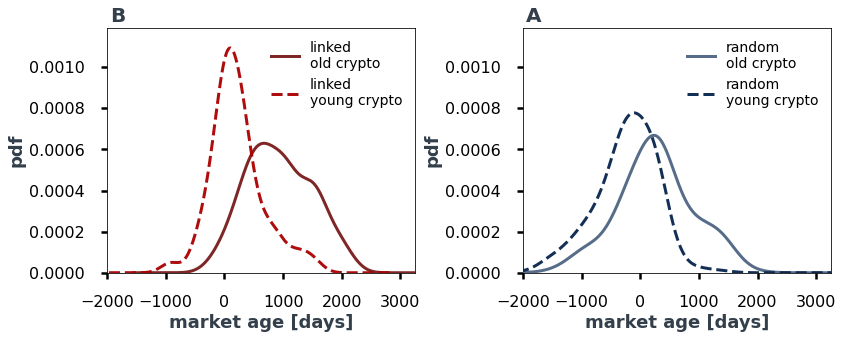

In [206]:
fig = plt.figure(figsize=(12,5))

tune = stats.gaussian_kde(old_market_age).covariance_factor()
# plot connected couples old/new age at connection time
ax = plt.subplot(121)
pd.Series(old_market_age).plot.kde(bw_method=tune, color='#781A1A',alpha=0.95, linewidth=3, label='linked\nold crypto',zorder=3)
pd.Series(new_market_age).plot.kde(bw_method=tune, color='#AB0000',alpha=0.95, linewidth=3, linestyle='--', label='linked\nyoung crypto',zorder=3)

plt.xlim(-2000,3250)
plt.ylim(-0.00000025,.00119)
# plt.grid(alpha=0.25)
plt.legend(frameon=False,fontsize=14)
# plot random couples old/new age at connection time
axx = plt.subplot(122)
pd.Series(Rold_market_age).plot.kde(bw_method=tune, color='#4E6482',alpha=0.95, linewidth=3, linestyle='-', label='random\nold crypto',zorder=3)
pd.Series(Rnew_market_age).plot.kde(bw_method=tune, color='#06244C',alpha=0.95, linewidth=3, linestyle='--', label='random\nyoung crypto',zorder=3)

plt.xlim(-2000,3250)
plt.ylim(-0.00000025,.00119)
# plt.grid(alpha=0.25)
plt.legend(frameon=False,fontsize=14)

ax.text(0.01,1.025,'B',fontsize=f_size+2, transform=ax.transAxes, weight='black',color='#333F4B')
axx.text(0.01,1.025,'A',fontsize=f_size+2, transform=axx.transAxes, weight='black',color='#333F4B')

ax.set_ylabel('pdf',fontsize=f_size, fontweight='black',color = '#333F4B')
ax.set_xlabel('market age [days]',fontsize=f_size, fontweight='black',color = '#333F4B')
axx.set_ylabel('pdf',fontsize=f_size, fontweight='black',color = '#333F4B')
axx.set_xlabel('market age [days]',fontsize=f_size, fontweight='black',color = '#333F4B')

plt.tight_layout()
fig.subplots_adjust(wspace=0.35,hspace=0.2) 
plt.savefig('figures/S13_rebuttal.pdf')

## Supplementary Information: Figure S14

KStest: Age (0.2555938910738943, 1.640581361676079e-12)
Ttest: Age (6.678984624177717, 2.0375647480355742e-10)
KStest (inc): Age (0.12198340874811463, 0.4110823905059775)
Ttest (inc): Age (0.731497315561513, 0.4655539183491827)

KStest: Age Diffs (0.19352189295731909, 0.0006866726179049654)
Ttest: Age Diffs (3.669250477739553, 0.0003814435140606782)
KStest (inc): Age Diffs (0.03449697636063771, 0.9999999729137286)
Ttest (inc): Age Diffs (0.10425393995841771, 0.9171116188520292)


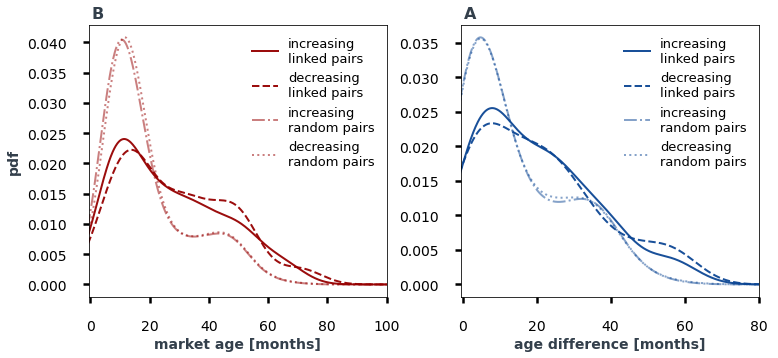

In [246]:
## For supplementary matherial add into "AGE analysis"
price = pd.read_pickle('export/df_price.pkl')
pairs = pd.read_pickle('conn_couples.pkl')[['org1','org2','coll_begins']]
pairsRT = pd.read_pickle('rand_conn_time_couples.pkl')[['org1','org2','coll_begins']]

pairsRT = pairsRT.merge(pairs[['org1','org2']],on=['org1','org2'], indicator=True,how='left').query('_merge=="left_only"').drop('_merge', axis=1).reset_index(drop=True)
pairsRT = pairsRT.rename(columns={'org1':'org2','org2':'org1'}).merge(pairs[['org1','org2']],on=['org1','org2'], indicator=True,how='left').query('_merge=="left_only"').drop('_merge', axis=1).reset_index(drop=True)

### Linked pairs
conn_couples = df.merge(pd.read_pickle('conn_couples.pkl'),on=['org1','org2','coll_begins'])[['org1','org2','coll_begins','coin_age1','coin_age2','before','after']]
conn_couples['market_age1_months'] = (conn_couples.coll_begins-conn_couples.coin_age1).dt.days/30
conn_couples['market_age2_months'] = (conn_couples.coll_begins-conn_couples.coin_age2).dt.days/30

ages = (conn_couples.market_age1_months.append(conn_couples.market_age2_months)).values
agediffs = (conn_couples.market_age1_months-conn_couples.market_age2_months).abs().values
increasing = conn_couples[conn_couples.before<=conn_couples.after]
inc_ages = (increasing.market_age1_months.append(increasing.market_age2_months)).values
inc_agediffs = np.abs(increasing.market_age1_months-increasing.market_age2_months)

decreasing = conn_couples[conn_couples.before>conn_couples.after]
dec_ages = (decreasing.market_age1_months.append(decreasing.market_age2_months)).values
dec_agediffs = np.abs(decreasing.market_age1_months-decreasing.market_age2_months)

### Random Pairs
rt_couples = pd.read_pickle('rand_conn_time_couples.pkl').rename(columns={'org1':'org2','org2':'org1'})
rt_couples = rt_couples.merge(pairsRT,on=['org1','org2','coll_begins'])
rt_couples['coin_age1'] = rt_couples.org1.apply(lambda x: price[x].first_valid_index())
rt_couples['coin_age2'] = rt_couples.org2.apply(lambda x: price[x].first_valid_index())
rt_couples = dfrt.set_index('name').merge(rt_couples,left_index=True,right_index=True,suffixes=('','_copy'))[['org1','org2','coll_begins','coin_age1','coin_age2','before','after']]
rt_couples['market_age1_months'] = (rt_couples.coll_begins-rt_couples.coin_age1).dt.days/30
rt_couples['market_age2_months'] = (rt_couples.coll_begins-rt_couples.coin_age2).dt.days/30

Rages = (rt_couples.market_age1_months.append(rt_couples.market_age2_months)).values
Ragediffs = (rt_couples.market_age1_months-rt_couples.market_age2_months).abs().values
Rincreasing = rt_couples[rt_couples.before<=rt_couples.after]
Rinc_ages = (Rincreasing.market_age1_months.append(Rincreasing.market_age2_months)).values
Rinc_agediffs = np.abs(Rincreasing.market_age1_months-Rincreasing.market_age2_months)

Rdecreasing = rt_couples[rt_couples.before>rt_couples.after]
Rdec_ages = (Rdecreasing.market_age1_months.append(Rdecreasing.market_age2_months)).values
Rdec_agediffs = np.abs(Rdecreasing.market_age1_months-Rdecreasing.market_age2_months)


### ############## plot
### 1.1 plot -- market cap differences
### Tabella in cui riassumiamo i valori di guadagno in correlazione rispetto alla media di tutta l'ecologia
### (e plot con linee e punti per anno) ... per girare LANCIARE la CELLA PRECEDENTE!!!
### corr_conn_couples, corr_githubs, corr_backgro, std_conn_couples, std_githubs, std_backgro
fig,ax = plt.subplots(1,2,figsize=(12,5))
f_size=14

Rag = Rages[(Rages<2e11)]
ag = ages[(ages<2e11)]
inc_ag = inc_ages[(inc_ages<2e11)]
dec_ag = dec_ages[(dec_ages<2e11)]
Rinc_ag = Rinc_ages[(Rinc_ages<2e11)]
Rdec_ag = Rdec_ages[(Rdec_ages<2e11)]
tune = stats.gaussian_kde(inc_ag).covariance_factor()

## Plot numpy histograms of the conn_couples differences distributions (x= diff, y=percentage of cryptoconn_couples)
pd.Series(inc_ag).plot.kde(ax=ax[0], bw_method=tune, linestyle='-', alpha=0.95, color='#960000',label='increasing\nlinked pairs')#label=' \n ')
pd.Series(dec_ag).plot.kde(ax=ax[0], bw_method=tune, linestyle='--', alpha=0.95, color='#960000',label='decreasing\nlinked pairs')#label=' \n ')
pd.Series(Rinc_ag).plot.kde(ax=ax[0], bw_method=tune, linestyle='-.', alpha=0.5, color='#960000',label='increasing\nrandom pairs')#label=' \n ')
pd.Series(Rdec_ag).plot.kde(ax=ax[0], bw_method=tune, linestyle=':', alpha=0.5, color='#960000',label='decreasing\nrandom pairs')#label=' \n ')

ax[0].grid(False)
ax[0].legend(fontsize=f_size-1,frameon=False)# loc=(2.262,0.075))
ax[0].set_ylabel('')
ax[0].set_xlabel('market age [months]',fontsize=f_size, fontweight='black',color = '#333F4B')
# plt.set_ylim((-1e-5,.9e-3))
ax[0].set_xlim((-.5,100))


### 1.2 plot -- transaction volume differences
Ragd = Ragediffs[(Ragediffs<2e11)]
agd = agediffs[(agediffs<2e11)]
inc_agd = inc_agediffs[(inc_agediffs<2e11)]
dec_agd = dec_agediffs[(dec_agediffs<2e11)]
Rinc_agd = Rinc_agediffs[(Rinc_agediffs<2e11)]
Rdec_agd = Rdec_agediffs[(Rdec_agediffs<2e11)]
tune = stats.gaussian_kde(inc_agd).covariance_factor()

## Plot numpy histograms of the conn_couples differences distributions (x= diff, y=percentage of cryptoconn_couples)
pd.Series(inc_agd).plot.kde(ax=ax[1], bw_method=tune, linestyle='-', alpha=0.95, color='#0C4694',label='increasing\nlinked pairs')
pd.Series(dec_agd).plot.kde(ax=ax[1], bw_method=tune, linestyle='--', alpha=0.95, color='#0C4694',label='decreasing\nlinked pairs')
pd.Series(Rinc_agd).plot.kde(ax=ax[1], bw_method=tune, linestyle='-.', alpha=0.5, color='#0C4694',label='increasing\nrandom pairs')
pd.Series(Rdec_agd).plot.kde(ax=ax[1], bw_method=tune, linestyle=':', alpha=0.5, color='#0C4694',label='decreasing\nrandom pairs')


ax[1].grid(False)
ax[1].legend(fontsize=f_size-1,frameon=False)# loc=(1.01,0.05))
ax[1].set_ylabel('')
ax[1].set_xlabel('age difference [months]',fontsize=f_size, fontweight='black',color = '#333F4B')
# plt.set_ylim((-1.2e-5,1.05e-3))
ax[1].set_xlim((-.5,80))

ax[0].text(0.01,1.025,'B',fontsize=f_size+2, transform=ax[0].transAxes, weight='black',color='#333F4B')
ax[1].text(0.01,1.025,'A',fontsize=f_size+2, transform=ax[1].transAxes, weight='black',color='#333F4B')
ax[0].tick_params('both',labelsize=f_size)
ax[1].tick_params('both',labelsize=f_size)


fig.subplots_adjust(wspace=.25,hspace=0.05)

ax1 = fig.add_subplot(111, zorder=0, facecolor='None')
ax1.spines['top'].set_color('None')
ax1.spines['bottom'].set_color('None')
ax1.spines['left'].set_color('None')
ax1.spines['right'].set_color('None')
ax1.tick_params(labelcolor='None', top=False, bottom=False, left=False, right=False)

ax1.set_ylabel('pdf\n', fontsize=f_size, fontweight='black',color = '#333F4B');

### Evaluate possible differences in market cap an transaction volume (k-s test and t-test)
print('KStest: Age',stats.ks_2samp(ag,Rag)[0:2])
print('Ttest: Age',stats.ttest_ind(ag,Rag,equal_var=False,nan_policy='omit')[0:2])
print('KStest (inc): Age',stats.ks_2samp(dec_ag,inc_ag)[0:2])
print('Ttest (inc): Age',stats.ttest_ind(dec_ag,inc_ag,equal_var=False,nan_policy='omit')[0:2])
# print('Wilco: MrCap Diffs',wilcoxon(ages,Rages,correction=True,)[0:2])
# print('Kr-Wa: MrCap Diffs',kruskal(ages,Rages,nan_policy='omit')[0:2])
print('')
print('KStest: Age Diffs',stats.ks_2samp(agd,Ragd)[0:2])
print('Ttest: Age Diffs',stats.ttest_ind(agd,Ragd,equal_var=False,nan_policy='omit')[0:2])
print('KStest (inc): Age Diffs',stats.ks_2samp(agd,inc_agd)[0:2])
print('Ttest (inc): Age Diffs',stats.ttest_ind(agd,inc_agd,equal_var=False,nan_policy='omit')[0:2])
# print('Wilco: TrVol Diffs',wilcoxon(agediffs,Ragediffs,correction=True,)[0:2])
# print('Kr-Wa: TrVol Diffs',kruskal(agediffs,Ragediffs,nan_policy='omit')[0:2])

# plt.subplots_adjust(wspace=0.35)
plt.savefig('figures/S14_rebuttal.pdf')

## Supplementary Information: Figure S15

Average mrcap former 16449313420.14 and latter 5410087652.36
Average trvol former 117501755.1 and latter 102624495599818.86


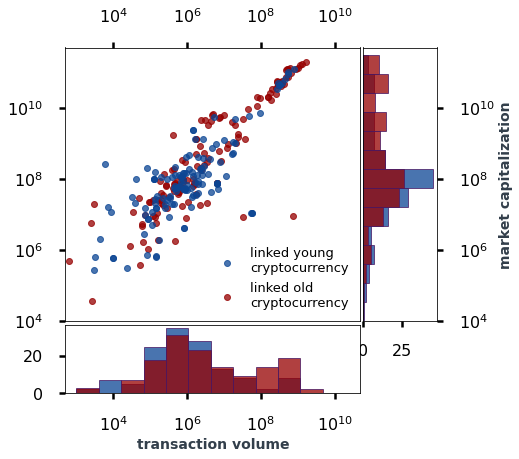

In [209]:
import matplotlib.gridspec as gridspec
from scipy import stats

### Coupling scattering mrcap and trvol before the connection time
couples = pd.read_pickle('conn_couples.pkl')
couples.reset_index(drop=True,inplace=True)
mrcap = pd.read_pickle('export/df_mrcap.pkl')
trvol = pd.read_pickle('export/df_volum.pkl')
mrcap.drop('year',axis=1,inplace=True)
trvol.drop('year',axis=1,inplace=True)

mrc_latter = np.zeros(len(couples))
mrc_former = np.zeros(len(couples))
trv_latter = np.zeros(len(couples))
trv_former = np.zeros(len(couples))
for i,couple in couples.iterrows():
    mrc = mrcap[mrcap.index<couple.coll_begins][[couple.org_latter,couple.org_former]].dropna()
    trv = trvol[trvol.index<couple.coll_begins][[couple.org_latter,couple.org_former]].dropna()
    if len(mrc)>0:
        mrc_latter[i] = mrc[couple.org_latter].mean()
        mrc_former[i] = mrc[couple.org_former].mean()
    else:
        mrc_latter[i] = np.nan
        mrc_former[i] = np.nan
    if len(trv)>0:
        trv_latter[i] = trv[couple.org_latter].mean()
        trv_former[i] = trv[couple.org_former].mean()
    else:
        trv_latter[i] = np.nan
        trv_former[i] = np.nan
print('Average mrcap former {} and latter {}'.format(round(np.nanmean(mrc_former),2),round(np.nanmean(mrc_latter),2)))
print('Average trvol former {} and latter {}'.format(round(np.nanmean(trv_former),2),round(np.nanmean(trv_latter),2)))


######################################################################################################################
######################################################################################################################
######################################################################################################################

fig, ax = plt.subplots(figsize=(6,6))
n_bins = 15
y_lim = (1e4,5e11)
x_lim = (5e2,5e10)
# Now, create the gridspec structure, as required
gs = gridspec.GridSpec(2,3, height_ratios=[1,0.25], width_ratios=[0.05,1,0.25])
# Also make sure the margins and spacing are apropriate
gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.02, hspace=0.02)
# Aggiungiamo il titolo a tutta la figura
# ax.suptitle('Before and after connection',fontsize=size+2,fontweight='black',color = '#333F4B')
ax1h = plt.subplot(gs[0,1])
ax1h.set_ylim(y_lim)
ax1h.set_xlim(x_lim)
ax1h.set_xscale('log')
ax1h.set_yscale('log')
ax1h.yaxis.tick_left()
ax1h.xaxis.tick_top()
# print(stats.ttest_ind(x_couples,y_couples,equal_var=False,nan_policy='omit'))
# print(stats.ks_2samp(x_rand,x_couples))
# print(stats.ks_2samp(y_rand,y_couples))

ax1h.scatter(trv_latter,mrc_latter,alpha=0.75,label='linked young\ncryptocurrency',color='#0C4694',zorder=3)
ax1h.scatter(trv_former,mrc_former,alpha=0.75,label='linked old\ncryptocurrency',color='#960000',zorder=2)
ax1h.grid(False)
ax1h.legend(fontsize=f_size-1,loc=4,frameon=False)


# distribuzioni laterali
ax1v = plt.subplot(gs[0,2])
ax1v.hist(mrc_latter, bins=np.logspace(4,11.5,n_bins), orientation='horizontal', range=y_lim,
          color='#0C4694', edgecolor='#491A65', alpha=0.75, density=False)
ax1v.hist(mrc_former, bins=np.logspace(4,11.5,n_bins), orientation='horizontal', range=y_lim,
          color='#960000', edgecolor='#491A65', alpha=0.75, density=False)
ax1v.grid(False)
ax1v.yaxis.tick_right()
ax1v.xaxis.tick_bottom()
# ax1v.tick_params('both', colors='#491A65')
ax1v.set_ylim(y_lim)
ax1v.set_ylabel('market capitalization',fontsize=f_size,fontweight='black',color = '#333F4B')
ax1v.yaxis.set_label_position("right")

ax2v = plt.subplot(gs[1,1])
ax2v.hist(trv_latter, bins=np.logspace(3,11.5,n_bins), orientation='vertical', range=x_lim,
          color='#0C4694', edgecolor='#491A65', alpha=0.75, density=False)
ax2v.hist(trv_former, bins=np.logspace(3,11.5,n_bins), orientation='vertical', range=x_lim,
          color='#960000', edgecolor='#491A65', alpha=0.75, density=False)
ax2v.grid(False)
ax2v.yaxis.tick_left()
ax2v.xaxis.tick_bottom()
# ax2v.tick_params('both', colors='#491A65')
ax2v.set_xlim(x_lim)
ax2v.set_xlabel('transaction volume',fontsize=f_size,fontweight='black',color = '#333F4B');
ax2v.set_xscale('log')
ax1v.set_yscale('log')
plt.savefig('figures/S15_rebuttal.pdf')

## Supplementary Information: Figure S16

KStest: RR (0.10266847580280417, 0.8149637657238609)
Ttest: PP (0.7751443205602396, 0.4396990326812623)
KStest (R-P): Age (0.15384615384615385, 0.7522620106454394)
Ttest (Rinc-Pinc): Age (-1.4598912816343759, 0.14981537072451637)

KStest: RR Diffs (0.1323529411764706, 0.5942919376585678)
Ttest: PP Diffs (0.6836160766719547, 0.4956158704963324)
KStest (R-P): Age Diffs (0.2564102564102564, 0.15467423743927008)
Ttest (Rinc-Pinc): Age Diffs (-2.2000172074452395, 0.032609274854121184)


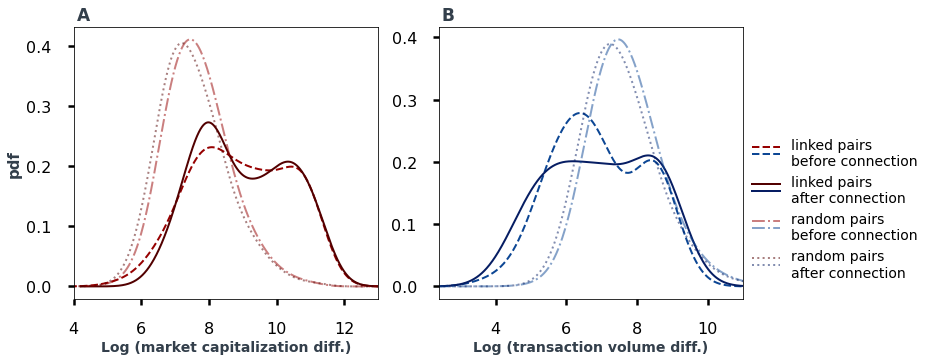

In [210]:
transition = 60
WIN_SIZE = 120
def shifted_series_diff(x):
    org1, org2, coll_begins = x
    tmp = series[[org1,org2]]
    tmp.index = (tmp.index-coll_begins).days
    Btmp = tmp.loc[-WIN_SIZE:-1]
    Atmp = tmp.loc[transition:transition+WIN_SIZE]
    return (np.abs(Btmp[org1]-Btmp[org2])).mean(),(np.abs(Atmp[org1]-Atmp[org2])).mean()

### DIFFERENCE BEFORE AND DIFFERENCE AFTER (only connected pairs)
df_scatter = df.copy()
rdf_scatter = dfrt.copy()
series = mrcap.copy()
res = (df_scatter[['org1','org2','coll_begins']].apply(shifted_series_diff,axis=1))
Rres = (rdf_scatter[['org1','org2','coll_begins']].apply(shifted_series_diff,axis=1))
Bmrcap = np.array([res.values[i][0] for i in range(len(list(res)))])
Bmrcap = Bmrcap[~np.isnan(Bmrcap)]
Amrcap = np.array([res.values[i][1] for i in range(len(list(res)))])
Amrcap = Amrcap[~np.isnan(Amrcap)]
RBmrcap = np.array([Rres.values[i][0] for i in range(len(list(Rres)))])
RBmrcap = RBmrcap[~np.isnan(RBmrcap)]
RAmrcap = np.array([Rres.values[i][1] for i in range(len(list(Rres)))])
RAmrcap = RAmrcap[~np.isnan(RAmrcap)]
series = trvol.copy()
res = (df_scatter[['org1','org2','coll_begins']].apply(shifted_series_diff,axis=1))
Btrvol = np.array([res.values[i][0] for i in range(len(list(res)))])
Atrvol = np.array([res.values[i][1] for i in range(len(list(res)))])
RBtrvol = np.array([Rres.values[i][0] for i in range(len(list(Rres)))])
RBtrvol = RBtrvol[~np.isnan(RBtrvol)]
RAtrvol = np.array([Rres.values[i][1] for i in range(len(list(Rres)))])
RAtrvol = RAtrvol[~np.isnan(RAtrvol)]


### ############## plot
### 1.1 plot -- market cap differences
fig = plt.figure(figsize=(12,5))
f_size=15

axx = plt.subplot(1,2,1)
BM = Bmrcap[(Bmrcap<2e11)]
AM = Amrcap[(Amrcap<2e11)]
RBM = RBmrcap[(RBmrcap<2e11)]
RAM = RAmrcap[(RAmrcap<2e11)]
tune = stats.gaussian_kde(np.log10(BM)).covariance_factor()

## Plot numpy histograms of the couples differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(BM)).plot.kde(ax=axx, bw_method=tune, linestyle='--', color='#960000',label=' \n ',lw=2)
pd.Series(np.log10(AM)).plot.kde(ax=axx, bw_method=tune, linestyle='-',color='#520000',label=' \n ')
## Plot numpy histograms of the background differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(RBM)).plot.kde(ax=axx, bw_method=tune, linestyle='-.', alpha=0.5, color='#960000',label=' \n ')
pd.Series(np.log10(RAM)).plot.kde(ax=axx, bw_method=tune, linestyle=':', alpha=0.5, color='#520000',label=' \n ')

plt.grid(False)
plt.legend(fontsize=f_size-1, loc=(2.21,0.075),frameon=False)
plt.ylabel('')
plt.xlabel('Log (market capitalization diff.)',fontsize=f_size-1, fontweight='black',color = '#333F4B')
# plt.ylim((8e-7,4.5e-1))
# plt.yscale('log')
plt.xlim((4,13))
# plt.xticks(list(range(4,13,2)),['$10^4$','$10^6$','$10^8$','$10^{10}$','$10^{12}$'])

### 1.2 plot -- transaction trvole differences
ax = plt.subplot(1,2,2)
BV = Btrvol[(Btrvol<2e11)]
RBV = RBtrvol[(RBtrvol<2e11)]
AV = Atrvol[(Atrvol<2e11)]
RAV = RAtrvol[(RAtrvol<2e11)]
tune = stats.gaussian_kde(np.log10(DBV)).covariance_factor()

## Plot numpy histograms of the couples differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(BV)).plot.kde(ax=ax, bw_method=tune, linestyle='--', color='#0C4694',label='linked pairs\nbefore connection',lw=2)
pd.Series(np.log10(AV)).plot.kde(ax=ax, bw_method=tune, linestyle='-', color='#061D63',label='linked pairs\nafter connection')
## Plot numpy histograms of the background differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(RBV)).plot.kde(ax=ax, bw_method=tune, linestyle='-.', alpha=0.5, color='#0C4694',label='random pairs\nbefore connection')
pd.Series(np.log10(RAV)).plot.kde(ax=ax, bw_method=tune, linestyle=':', alpha=0.5, color='#061D63',label='random pairs\nafter connection')


plt.grid(False)
plt.legend(fontsize=f_size-1, loc=(1.01,0.05),frameon=False)
plt.ylabel('')
plt.xlabel('Log (transaction volume diff.)',fontsize=f_size-1, fontweight='black',color = '#333F4B')
# plt.ylim((8e-7,4.5e-1))
# plt.yscale('log')
plt.xlim((2.4,11.))
# plt.xticks(list(range(2,13,2)),['$10^2$','$10^4$','$10^6$','$10^8$','$10^{10}$','$10^{12}$'])

ax.text(0.01,1.025,'B',fontsize=f_size+2, transform=ax.transAxes, weight='black',color='#333F4B')
axx.text(0.01,1.025,'A',fontsize=f_size+2, transform=axx.transAxes, weight='black',color='#333F4B')



ax1 = fig.add_subplot(111, zorder=0, facecolor='None')
ax1.spines['top'].set_color('None')
ax1.spines['bottom'].set_color('None')
ax1.spines['left'].set_color('None')
ax1.spines['right'].set_color('None')
ax1.tick_params(labelcolor='None', top=False, bottom=False, left=False, right=False)

ax1.set_ylabel('pdf', fontsize=f_size, fontweight='black',color = '#333F4B');

### Evaluate possible differences in market cap an transaction volume (k-s test and t-test)
print('KStest: RR',stats.ks_2samp(IBM,IAM)[0:2])
print('Ttest: PP',stats.ttest_ind(IBM,IAM,equal_var=False,nan_policy='omit')[0:2])
print('KStest (R-P): Age',stats.ks_2samp(DBM,DAM)[0:2])
print('Ttest (Rinc-Pinc): Age',stats.ttest_ind(DBM,DAM,equal_var=False,nan_policy='omit')[0:2])

print('')
print('KStest: RR Diffs',stats.ks_2samp(IBV,IAV)[0:2])
print('Ttest: PP Diffs',stats.ttest_ind(IBV,IAV,equal_var=False,nan_policy='omit')[0:2])
print('KStest (R-P): Age Diffs',stats.ks_2samp(DBV,DAV)[0:2])
print('Ttest (Rinc-Pinc): Age Diffs',stats.ttest_ind(DBV,DAV,equal_var=False,nan_policy='omit')[0:2])

plt.savefig('figures/S16_rebuttal.pdf')


## Supplementary Information: Figure S17

KStest: MrCap  (0.49353848639043696, 3.0007605289483763e-09)
Ttest: MrCap  (4.2580175918296295, 0.00013033030736431885)
KStest (inc): MrCap  (0.09125188536953242, 0.9685371351445965)
Ttest (inc): MrCap  (-0.18662601758415273, 0.8524374611684709)

KStest: TrVol  (0.4691676338915603, 5.8253329160429246e-08)
Ttest: TrVol  (-2.6766632885672657, 0.007950559975584361)
KStest (inc): TrVol  (0.12042925278219396, 0.824214683133278)
Ttest (inc): TrVol  (0.45200026945967525, 0.6527865441601555)


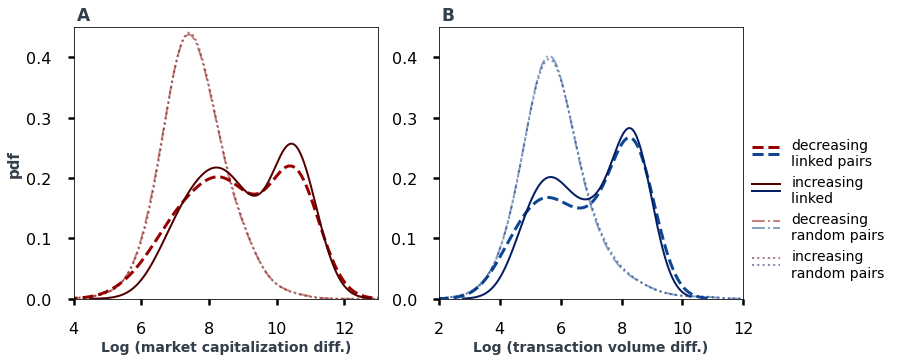

In [211]:
### INCREASING DECREASING
df_scatter = df.copy()
pairs = df_scatter.set_index('name')
tmp = df_scatter[df_scatter.after>df_scatter.before]
inc_mrcap = pd.Series(np.abs(mrcap[tmp.org1].mean(axis=0).values-mrcap[tmp.org2].mean(axis=0).values)).dropna()
inc_trvol = pd.Series(np.abs(trvol[tmp.org1].mean(axis=0).values-trvol[tmp.org2].mean(axis=0).values)).dropna()
tmp = df_scatter[df_scatter.after<df_scatter.before]
dec_mrcap = pd.Series(np.abs(mrcap[tmp.org1].mean(axis=0).values-mrcap[tmp.org2].mean(axis=0).values)).dropna()
dec_trvol = pd.Series(np.abs(trvol[tmp.org1].mean(axis=0).values-trvol[tmp.org2].mean(axis=0).values)).dropna()

rt_pairs = pd.read_pickle('rand_conn_time_couples.pkl')
tmp = sample[sample.after>sample.before]
Rinc_mrcap = pd.Series(np.abs(mrcap[rt_pairs.loc[tmp.name].org1].mean(axis=0).values-mrcap[rt_pairs.loc[tmp.name].org2].mean(axis=0).values)).dropna()
Rinc_trvol = pd.Series(np.abs(trvol[rt_pairs.loc[tmp.name].org1].mean(axis=0).values-trvol[rt_pairs.loc[tmp.name].org2].mean(axis=0).values)).dropna()
tmp = sample[sample.after<sample.before]
Rdec_mrcap = pd.Series(np.abs(mrcap[rt_pairs.loc[tmp.name].org1].mean(axis=0).values-mrcap[rt_pairs.loc[tmp.name].org2].mean(axis=0).values)).dropna()
Rdec_trvol = pd.Series(np.abs(trvol[rt_pairs.loc[tmp.name].org1].mean(axis=0).values-trvol[rt_pairs.loc[tmp.name].org2].mean(axis=0).values)).dropna()


### ############## plot
### 1.1 plot -- market cap differences
### Tabella in cui riassumiamo i valori di guadagno in correlazione rispetto alla media di tutta l'ecologia
### (e plot con linee e punti per anno) ... per girare LANCIARE la CELLA PRECEDENTE!!!
### corr_couples, corr_githubs, corr_backgro, std_couples, std_githubs, std_backgro
fig = plt.figure(figsize=(12,5))

Rmrc = Rdec_mrcap[(Rdec_mrcap<2e11)]
mrc = dec_mrcap[(dec_mrcap<2e11)]
inc_mrc = inc_mrcap[(inc_mrcap<2e11)]
Rinc_mrc = Rinc_mrcap[(Rinc_mrcap<2e11)]
tune = stats.gaussian_kde(np.log10(mrc)).covariance_factor()
axx = plt.subplot(1,2,1)

## Plot numpy histograms of the couples differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(mrc)).plot.kde(bw_method=tune, linestyle='--', color='#960000',label=' \n ',lw=3)
## Plot numpy histograms of the background differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(inc_mrc)).plot.kde(bw_method=tune, linestyle='-',color='#520000',label=' \n ')
pd.Series(np.log10(Rmrc)).plot.kde(bw_method=tune, linestyle='-.', alpha=0.5, color='#960000',label=' \n ')
pd.Series(np.log10(Rinc_mrc)).plot.kde(bw_method=tune, linestyle=':', alpha=0.5, color='#520000',label=' \n ')

plt.grid(False)
plt.legend(fontsize=f_size-1, loc=(2.21,0.075),frameon=False)
plt.ylabel('')
plt.xlabel('Log (market capitalization diff.)',fontsize=f_size-1, fontweight='black',color = '#333F4B')
plt.ylim((0,4.5e-1))
# plt.yscale('log')
plt.xlim((4,13))
# plt.xticks(list(range(4,13,2)),['$10^4$','$10^6$','$10^8$','$10^{10}$','$10^{12}$'])

### 1.2 plot -- transaction volume differences

Rtrv = Rdec_trvol[(Rdec_trvol<2e11)]
trv = dec_trvol[(dec_trvol<2e11)]
inc_trv = inc_trvol[(inc_trvol<2e11)]
Rinc_trv = Rinc_trvol[(Rinc_trvol<2e11)]
tune = stats.gaussian_kde(np.log10(trv)).covariance_factor()
ax = plt.subplot(1,2,2)

## Plot numpy histograms of the couples differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(trv)).plot.kde(bw_method=tune, linestyle='--', color='#0C4694',label='decreasing\nlinked pairs',lw=3)
## Plot numpy histograms of the background differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(inc_trv)).plot.kde(bw_method=tune, linestyle='-', color='#061D63',label='increasing\nlinked ')
pd.Series(np.log10(Rtrv)).plot.kde(bw_method=tune, linestyle='-.', alpha=0.5, color='#0C4694',label='decreasing\nrandom pairs')
pd.Series(np.log10(Rinc_trv)).plot.kde(bw_method=tune, linestyle=':', alpha=0.5, color='#061D63',label='increasing\nrandom pairs')

ax.text(0.01,1.025,'B',fontsize=f_size+2, transform=ax.transAxes, weight='black',color='#333F4B')
axx.text(0.01,1.025,'A',fontsize=f_size+2, transform=axx.transAxes, weight='black',color='#333F4B')


plt.grid(False)
plt.legend(fontsize=f_size-1, loc=(1.01,0.05),frameon=False)
plt.ylabel('')
plt.xlabel('Log (transaction volume diff.)',fontsize=f_size-1, fontweight='black',color = '#333F4B')
plt.ylim((0,4.5e-1))
plt.xlim((2,12))


ax1 = fig.add_subplot(111, zorder=0, facecolor='None')
ax1.spines['top'].set_color('None')
ax1.spines['bottom'].set_color('None')
ax1.spines['left'].set_color('None')
ax1.spines['right'].set_color('None')
ax1.tick_params(labelcolor='None', top=False, bottom=False, left=False, right=False)

ax1.set_ylabel('pdf', fontsize=f_size, fontweight='black',color = '#333F4B');

### Evaluate possible differences in market cap an transaction volume (k-s test and t-test)
print('KStest: MrCap ',stats.ks_2samp(mrc,Rmrc)[0:2])
print('Ttest: MrCap ',stats.ttest_ind(mrc,Rmrc,equal_var=False,nan_policy='omit')[0:2])
print('KStest (inc): MrCap ',stats.ks_2samp(mrc,inc_mrc)[0:2])
print('Ttest (inc): MrCap ',stats.ttest_ind(mrc,inc_mrc,equal_var=False,nan_policy='omit')[0:2])

print('')
print('KStest: TrVol ',stats.ks_2samp(trv,Rtrv)[0:2])
print('Ttest: TrVol ',stats.ttest_ind(trv,Rtrv,equal_var=False,nan_policy='omit')[0:2])
print('KStest (inc): TrVol ',stats.ks_2samp(trv,inc_trv)[0:2])
print('Ttest (inc): TrVol ',stats.ttest_ind(trv,inc_trv,equal_var=False,nan_policy='omit')[0:2])

plt.savefig('figures/S17_rebuttal.pdf')


## Supplementary Information: Figure S18

KStest: RR (0.10266847580280417, 0.8149637657238609)
Ttest: PP (0.7751443205602396, 0.4396990326812623)
KStest (R-P): Age (0.15384615384615385, 0.7522620106454394)
Ttest (Rinc-Pinc): Age (-1.4598912816343759, 0.14981537072451637)

KStest: RR Diffs (0.1323529411764706, 0.5942919376585678)
Ttest: PP Diffs (0.6836160766719547, 0.4956158704963324)
KStest (R-P): Age Diffs (0.2564102564102564, 0.15467423743927008)
Ttest (Rinc-Pinc): Age Diffs (-2.2000172074452395, 0.032609274854121184)


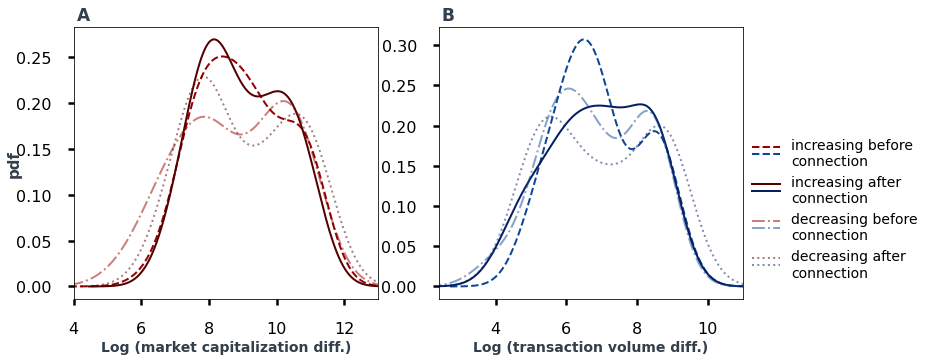

In [212]:
transition = 60
WIN_SIZE = 120
def shifted_series_diff(x):
    org1, org2, coll_begins = x
    tmp = series[[org1,org2]]
    tmp.index = (tmp.index-coll_begins).days
    Btmp = tmp.loc[-WIN_SIZE:-1]
    Atmp = tmp.loc[transition:transition+WIN_SIZE]
    return (np.abs(Btmp[org1]-Btmp[org2])).mean(),(np.abs(Atmp[org1]-Atmp[org2])).mean()

### DIFFERENCE BEFORE AND DIFFERENCE AFTER (only connected pairs)
df_scatter = df.copy()
pairs = df_scatter.set_index('name')
tmp = df_scatter[df_scatter.after>df_scatter.before]
series = mrcap.copy()
inc_res = (tmp[['org1','org2','coll_begins']].apply(shifted_series_diff,axis=1))
inc_Bmrcap = np.array([inc_res.values[i][0] for i in range(len(list(inc_res)))])
inc_Bmrcap = inc_Bmrcap[~np.isnan(inc_Bmrcap)]
inc_Amrcap = np.array([inc_res.values[i][1] for i in range(len(list(inc_res)))])
inc_Amrcap = inc_Amrcap[~np.isnan(inc_Amrcap)]
series = trvol.copy()
inc_res = (tmp[['org1','org2','coll_begins']].apply(shifted_series_diff,axis=1))
inc_Btrvol = np.array([inc_res.values[i][0] for i in range(len(list(inc_res)))])
inc_Atrvol = np.array([inc_res.values[i][1] for i in range(len(list(inc_res)))])

tmp = df_scatter[df_scatter.after<df_scatter.before]
series = mrcap.copy()
dec_res = (tmp[['org1','org2','coll_begins']].apply(shifted_series_diff,axis=1))
dec_Bmrcap = np.array([dec_res.values[i][0] for i in range(len(list(dec_res)))])
dec_Amrcap = np.array([dec_res.values[i][1] for i in range(len(list(dec_res)))])
series = trvol.copy()
dec_res = (tmp[['org1','org2','coll_begins']].apply(shifted_series_diff,axis=1))
dec_Btrvol = np.array([dec_res.values[i][0] for i in range(len(list(dec_res)))])
dec_Atrvol = np.array([dec_res.values[i][1] for i in range(len(list(dec_res)))])

### ############## plot
### 1.1 plot -- market cap differences
### Tabella in cui riassumiamo i valori di guadagno in correlazione rispetto alla media di tutta l'ecologia
### (e plot con linee e punti per anno) ... per girare LANCIARE la CELLA PRECEDENTE!!!
### corr_couples, corr_githubs, corr_backgro, std_couples, std_githubs, std_backgro
fig = plt.figure(figsize=(12,5))
f_size=15

axx = plt.subplot(1,2,1)
IBM = inc_Bmrcap[(inc_Bmrcap<2e11)]
DBM = dec_Bmrcap[(dec_Bmrcap<2e11)]
IAM = inc_Amrcap[(inc_Amrcap<2e11)]
DAM = dec_Amrcap[(dec_Amrcap<2e11)]
tune = stats.gaussian_kde(np.log10(DBM)).covariance_factor()

## Plot numpy histograms of the couples differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(IBM)).plot.kde(bw_method=tune, linestyle='--', color='#960000',label=' \n ',lw=2)
pd.Series(np.log10(IAM)).plot.kde(bw_method=tune, linestyle='-',color='#520000',label=' \n ')
## Plot numpy histograms of the background differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(DBM)).plot.kde(bw_method=tune, linestyle='-.', alpha=0.5, color='#960000',label=' \n ')
pd.Series(np.log10(DAM)).plot.kde(bw_method=tune, linestyle=':', alpha=0.5, color='#520000',label=' \n ')

plt.grid(False)
plt.legend(fontsize=f_size-1, loc=(2.21,0.075),frameon=False)
plt.ylabel('')
plt.xlabel('Log (market capitalization diff.)',fontsize=f_size-1, fontweight='black',color = '#333F4B')
# plt.ylim((8e-7,4.5e-1))
# plt.yscale('log')
plt.xlim((4,13))
# plt.xticks(list(range(4,13,2)),['$10^4$','$10^6$','$10^8$','$10^{10}$','$10^{12}$'])

### 1.2 plot -- transaction trvole differences
ax = plt.subplot(1,2,2)
IBV = inc_Btrvol[(inc_Btrvol<2e11)]
DBV = dec_Btrvol[(dec_Btrvol<2e11)]
IAV = inc_Atrvol[(inc_Atrvol<2e11)]
DAV = dec_Atrvol[(dec_Atrvol<2e11)]
tune = stats.gaussian_kde(np.log10(DBV)).covariance_factor()

## Plot numpy histograms of the couples differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(IBV)).plot.kde(bw_method=tune, linestyle='--', color='#0C4694',label='increasing before\nconnection',lw=2)
pd.Series(np.log10(IAV)).plot.kde(bw_method=tune, linestyle='-', color='#061D63',label='increasing after\nconnection')
## Plot numpy histograms of the background differences distributions (x= diff, y=percentage of cryptocouples)
pd.Series(np.log10(DBV)).plot.kde(bw_method=tune, linestyle='-.', alpha=0.5, color='#0C4694',label='decreasing before\nconnection')
pd.Series(np.log10(DAV)).plot.kde(bw_method=tune, linestyle=':', alpha=0.5, color='#061D63',label='decreasing after\nconnection')


plt.grid(False)
plt.legend(fontsize=f_size-1, loc=(1.01,0.05),frameon=False)
plt.ylabel('')
plt.xlabel('Log (transaction volume diff.)',fontsize=f_size-1, fontweight='black',color = '#333F4B')
# plt.ylim((8e-7,4.5e-1))
# plt.yscale('log')
plt.xlim((2.4,11.))
# plt.xticks(list(range(2,13,2)),['$10^2$','$10^4$','$10^6$','$10^8$','$10^{10}$','$10^{12}$'])
ax.text(0.01,1.025,'B',fontsize=f_size+2, transform=ax.transAxes, weight='black',color='#333F4B')
axx.text(0.01,1.025,'A',fontsize=f_size+2, transform=axx.transAxes, weight='black',color='#333F4B')



ax1 = fig.add_subplot(111, zorder=0, facecolor='None')
ax1.spines['top'].set_color('None')
ax1.spines['bottom'].set_color('None')
ax1.spines['left'].set_color('None')
ax1.spines['right'].set_color('None')
ax1.tick_params(labelcolor='None', top=False, bottom=False, left=False, right=False)

ax1.set_ylabel('pdf', fontsize=f_size, fontweight='black',color = '#333F4B');

### Evaluate possible differences in market cap an transaction volume (k-s test and t-test)
print('KStest: RR',stats.ks_2samp(IBM,IAM)[0:2])
print('Ttest: PP',stats.ttest_ind(IBM,IAM,equal_var=False,nan_policy='omit')[0:2])
print('KStest (R-P): Age',stats.ks_2samp(DBM,DAM)[0:2])
print('Ttest (Rinc-Pinc): Age',stats.ttest_ind(DBM,DAM,equal_var=False,nan_policy='omit')[0:2])
# print('Wilco: MrCap Diffs',wilcoxon(ages,Rages,correction=True,)[0:2])
# print('Kr-Wa: MrCap Diffs',kruskal(ages,Rages,nan_policy='omit')[0:2])
print('')
print('KStest: RR Diffs',stats.ks_2samp(IBV,IAV)[0:2])
print('Ttest: PP Diffs',stats.ttest_ind(IBV,IAV,equal_var=False,nan_policy='omit')[0:2])
print('KStest (R-P): Age Diffs',stats.ks_2samp(DBV,DAV)[0:2])
print('Ttest (Rinc-Pinc): Age Diffs',stats.ttest_ind(DBV,DAV,equal_var=False,nan_policy='omit')[0:2])
# print('Wilco: TrVol Diffs',wilcoxon(agediffs,Ragediffs,correction=True,)[0:2])
# print('Kr-Wa: TrVol Diffs',kruskal(agediffs,Ragediffs,nan_policy='omit')[0:2])

plt.savefig('figures/S18_rebuttal.pdf')


## Supplementary Information: Figure S19

In [ ]:
# Load the data...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from notebooks_functions import *

%matplotlib inline
def young_f(x):
    if x.coin_age1>=x.coin_age2:
        return x.org1
    else:
        return x.org2
def old_f(x):
    if x.coin_age1>=x.coin_age2:
        return x.org2
    else:
        return x.org1
def mrcap_before_f(x,mrcap):
    mrcap_mean = mrcap.loc[:x.coll_begins][x.org].mean()
    if np.isnan(mrcap_mean):
        return 0 
    else:
        return mrcap_mean
def vol_before_f(x,vol):
    vol_mean = vol.loc[:x.coll_begins][x.org].mean()
    if np.isnan(vol_mean):
        return 0 
    else:
        return vol_mean
def na_mrcap_before_f(x,mrcap):
    mrcap_mean = mrcap.loc[:x.coll_begins][x.org].mean()
    if np.isnan(mrcap_mean):
        return 0 
    else:
        return mrcap_mean
def na_vol_before_f(x,vol):
    vol_mean = vol.loc[:x.coll_begins][x.org].mean()
    if np.isnan(vol_mean):
        return 0 
    else:
        return vol_mean
def low_f(x):
    if x.mrcap_before1>=x.mrcap_before2:
        return x.org2
    else:
        return x.org1
def high_f(x):
    if x.mrcap_before1>=x.mrcap_before2:
        return x.org1
    else:
        return x.org2


df_tmp = pd.read_pickle('export/robustness/rp_retur_win120.pkl')
df_tmp.index = df_tmp.index.days
retur = pd.read_pickle('export/df_retur.pkl')
mrcap = pd.read_pickle('export/df_mrcap.pkl')
vol = pd.read_pickle('export/df_volum.pkl')
git_act = pd.read_pickle('export/git_data_pushpull_v4(vol1e5).pkl')



print('\n###################')
before = df_tmp.loc[-60:-0].mean(axis=0)
after = df_tmp.loc[0:60].mean(axis=0)
before = before.reset_index().rename(columns={0:'before'})[['before']]
before['org1'] = edges.org1
before['org2'] = edges.org2
bef_aft = before.copy()
bef_aft['after'] = after.values

edges = pd.read_pickle('conn_couples.pkl').sort_values('coll_begins').reset_index(drop=True)
edges = edges.merge(bef_aft, on=['org1','org2'],how='left')
### add columns for connection event type
eventstypes = []
for i, coupling in edges.iterrows():
    git_tmp = git_act[(git_act.sym==coupling.org_latterPP)&(git_act.actor_login==coupling.actors)&(git_act.date==coupling.coll_begins)]
    if len(git_tmp)>0:
        eventstypes.append(git_tmp['type'].iloc[0])
    else:
        print(coupling[['org1','org2','org_former','org_latter','coll_begins']])
edges['eventType'] = eventstypes
## rinominiamo una colonna in modo che contenga la prima editata dal connection editor e la seconda nella coppia
edges = edges.rename(columns={'org_formerPP':'firsts','org_latterPP':'new'})
## aggiungiamo a edges due colonne che contengano le crypto piú giovani sul mercato e quelle piú vecchie nella coppia
edges['young'] = edges[['org1','org2','coin_age1','coin_age2']].apply(lambda x: young_f(x),axis=1)
edges['old'] = edges[['org1','org2','coin_age1','coin_age2']].apply(lambda x: old_f(x),axis=1)
## due colonne che contengano le crypto con mrcap piú alto e mrcap piú basso nella coppia
edges['mrcap_before1'] = edges[['org1','coll_begins']].rename(columns={'org1':'org'}).apply(lambda x: mrcap_before_f(x,mrcap),axis=1)
edges['mrcap_before2'] = edges[['org2','coll_begins']].rename(columns={'org2':'org'}).apply(lambda x: mrcap_before_f(x,mrcap),axis=1)
edges['vol_before1'] = edges[['org1','coll_begins']].rename(columns={'org1':'org'}).apply(lambda x: vol_before_f(x,vol),axis=1)
edges['vol_before2'] = edges[['org2','coll_begins']].rename(columns={'org2':'org'}).apply(lambda x: vol_before_f(x,vol),axis=1)
edges['na_mrcap_before1'] = edges[['org1','coll_begins']].rename(columns={'org1':'org'}).apply(lambda x: na_mrcap_before_f(x,mrcap),axis=1)
edges['na_mrcap_before2'] = edges[['org2','coll_begins']].rename(columns={'org2':'org'}).apply(lambda x: na_mrcap_before_f(x,mrcap),axis=1)
edges['na_vol_before1'] = edges[['org1','coll_begins']].rename(columns={'org1':'org'}).apply(lambda x: na_vol_before_f(x,vol),axis=1)
edges['na_vol_before2'] = edges[['org2','coll_begins']].rename(columns={'org2':'org'}).apply(lambda x: na_vol_before_f(x,vol),axis=1)

edges['low'] = edges[['org1','org2','mrcap_before1','mrcap_before2']].apply(lambda x: low_f(x),axis=1)
edges['high'] = edges[['org1','org2','mrcap_before1','mrcap_before2']].apply(lambda x: high_f(x),axis=1)
## column with the difference between mrcaps
edges['mrcap_diff_before'] = np.abs(edges.mrcap_before1-edges.mrcap_before2)
## colonna con distanza dalla bisettrice (bisector)
edges['dist_lin'] = np.sign(edges.after-edges.before)*(edges.after-edges.before)/np.sqrt(2)
edges['pos_lin'] = (edges.after+edges.before)/np.sqrt(2)
## column with differences of mrcap and volume
edges['mrcap_diff'] = np.abs(edges.na_mrcap_before1-edges.na_mrcap_before2)
edges['volum_diff'] = np.abs(edges.na_vol_before1-edges.na_vol_before2)

# select the dataframe with non nan before/after values
ba_edges = edges[(edges.before.notna())&(edges.after.notna())].copy()

couples = ba_edges.copy().reset_index(drop=True)
git_act = pd.read_pickle('export/git_data_pushpull_v4(vol1e5).pkl')
### Number of push&pull before the connection and after the connection by collaborative editors
Borg_former = np.zeros(len(couples))
Aorg_former = np.zeros(len(couples))
Borg_latter = np.zeros(len(couples))
Aorg_latter = np.zeros(len(couples))

for i,couple in couples.iterrows():
    tmp_act1 = git_act[(git_act.actor_login==couple.actors)&(git_act.sym==couple.firsts)]
    tmp_act2 = git_act[(git_act.actor_login==couple.actors)&(git_act.sym==couple.new)]
    Borg_former[i] = len(tmp_act1[tmp_act1.date<couple.coll_begins])
    Aorg_former[i] = len(tmp_act1[tmp_act1.date>=couple.coll_begins])
    Borg_latter[i] = len(tmp_act2[tmp_act2.date<couple.coll_begins])
    Aorg_latter[i] = len(tmp_act2[tmp_act2.date>=couple.coll_begins])

ba_edges['elect-dismiss'] = [1 if j==0 else 0 for j in Aorg_former]

top10 = ba_edges[['high','mrcap_before1','mrcap_before2','coll_begins']].copy()
high_cap = list(top10[['mrcap_before1','mrcap_before2']].apply(lambda x: max(x),axis=1))
top10['h_cap'] = high_cap
top10 = top10[['high','h_cap','coll_begins']].sort_values('h_cap',ascending=False).drop_duplicates('high')
top10 = top10.head(10).high

ba_edges = ba_edges.sort_values('coll_begins')

In [ ]:
##################################################################################################################
## connessioni young->firsts contro young->new equal to old->new contro old->firsts
yf = ba_edges[(ba_edges.young==ba_edges.firsts)]
yn = ba_edges[(ba_edges.young==ba_edges.new)]

##################################################################################################################
# mrcap significantly select classes of connected cryptos?
measure = 'mrcap' # 'mrcap' or 'volum'
chdif = ba_edges.sort_values(f'{measure}_diff').tail(int(len(ba_edges)/2))
cldif = ba_edges.sort_values(f'{measure}_diff').head(int(len(ba_edges)/2))

###############################################################################################################
### Number of push&pull before the connection and after the connection by collaborative editors
cdismiss = ba_edges[ba_edges['elect-dismiss']==1]
ckeep = ba_edges[ba_edges['elect-dismiss']==0]

#################################################################################################################
## connessioni con le 10 crypto piú importanti come "firsts"
ctop = ba_edges[(ba_edges.high.isin(top10))]
cbot = ba_edges[~(ba_edges.high.isin(top10))]

##################################################################################################################
## couples born from push or pull?
cpush = ba_edges[(ba_edges.eventType=='PushEvent')]
cpull = ba_edges[(ba_edges.eventType=='PullRequestEvent')]

##################################################################################################################
## 50% connessioni piú vecchie 50% connessioni piú recenti
clate = ba_edges.tail(int(len(ba_edges)/2))
cearly = ba_edges.head(int(len(ba_edges)/2))

print('###################')
print('dismissed = ',round(len(cdismiss)/len(ba_edges),2))
print('kept = ',round(len(ckeep)/len(ba_edges),2))
print('-------------------')
print('We avg_diff p-val:',st.ttest_ind(cdismiss.dist_lin,ckeep.dist_lin,equal_var=False,nan_policy='omit')[1])
print('KS dist_diff p-val:',st.ks_2samp(cdismiss.dist_lin,ckeep.dist_lin)[1])
print('MW dist_diff p-val:',st.mannwhitneyu(cdismiss.dist_lin,ckeep.dist_lin)[1])
print('Mood dist_diff p-val:',st.median_test(cdismiss.dist_lin,ckeep.dist_lin)[1])
print('KW dist_diff p-val:',st.kruskal(cdismiss.dist_lin,ckeep.dist_lin)[1])
print('We avg_pos p-val:',st.ttest_ind(cdismiss.pos_lin,ckeep.pos_lin,equal_var=False,nan_policy='omit')[1])
print('KS dist_pos p-val:',st.ks_2samp(cdismiss.pos_lin,ckeep.pos_lin)[1])
print('MW dist_pos p-val:',st.mannwhitneyu(cdismiss.pos_lin,ckeep.pos_lin)[1])
print('Mood dist_pos p-val:',st.median_test(cdismiss.pos_lin,ckeep.pos_lin)[1])
print('KW dist_pos p-val:',st.kruskal(cdismiss.pos_lin,ckeep.pos_lin)[1])
print()
print('###################')
print('bottom = ',round(len(cbot)/len(ba_edges),2))
print('top10 = ',round(len(ctop)/len(ba_edges),2))
print('-------------------')
print('We avg_diff p-val:',st.ttest_ind(cbot.dist_lin,ctop.dist_lin,equal_var=False,nan_policy='omit')[1])
print('KS dist_diff p-val:',st.ks_2samp(cbot.dist_lin,ctop.dist_lin)[1])
print('MW dist_diff p-val:',st.mannwhitneyu(cbot.dist_lin,ctop.dist_lin)[1])
print('Mood dist_diff p-val:',st.median_test(cbot.dist_lin,ctop.dist_lin)[1])
print('KW dist_diff p-val:',st.kruskal(cbot.dist_lin,ctop.dist_lin)[1])
print('We avg_pos p-val:',st.ttest_ind(cbot.pos_lin,ctop.pos_lin,equal_var=False,nan_policy='omit')[1])
print('KS dist_pos p-val:',st.ks_2samp(cbot.pos_lin,ctop.pos_lin)[1])
print('MW dist_pos p-val:',st.mannwhitneyu(cbot.pos_lin,ctop.pos_lin)[1])
print('Mood dist_pos p-val:',st.median_test(cbot.pos_lin,ctop.pos_lin)[1])
print('KW dist_pos p-val:',st.kruskal(cbot.pos_lin,ctop.pos_lin)[1])


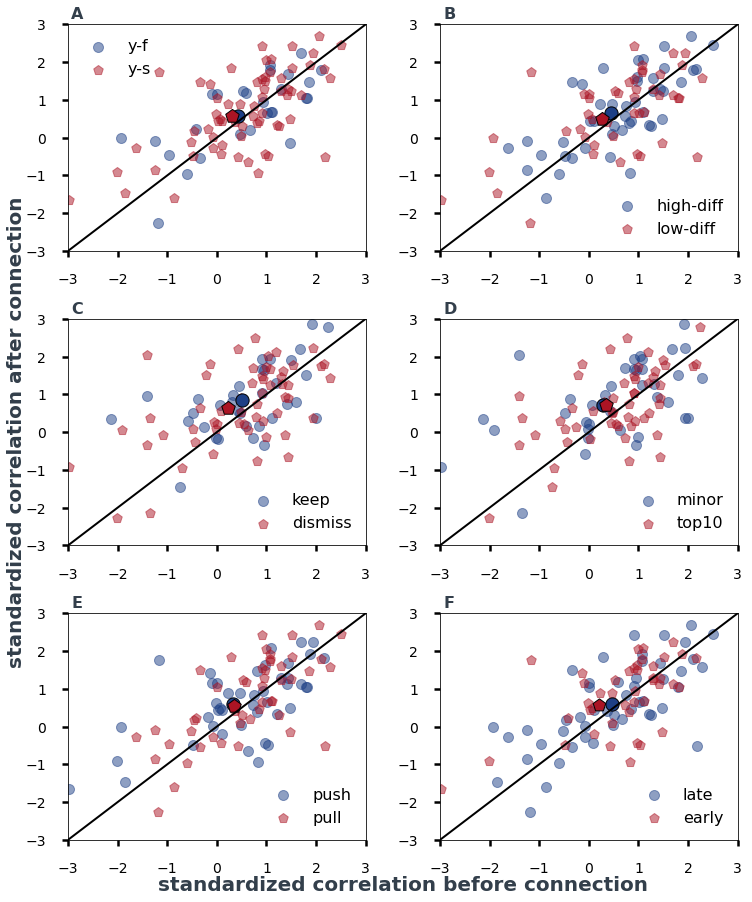

In [409]:
##################################################################################################################
##################################################################################################################
##################################################################################################################
c1 = '#1E4086'
c2 = '#AB1424'
f_size=14
x_len = 2
y_len = 3
size_point=100
size_avg=175

from scipy.stats import pearsonr,spearmanr
fig,ax = plt.subplots(y_len,x_len,figsize=(x_len*6,y_len*5))
ax[0,0].tick_params(labelsize=f_size)
ax[0,1].tick_params(labelsize=f_size)
ax[1,0].tick_params(labelsize=f_size)
ax[1,1].tick_params(labelsize=f_size)
ax[2,0].tick_params(labelsize=f_size)
ax[2,1].tick_params(labelsize=f_size)


ax[0,0].scatter(yf.before,yf.after,alpha=0.5,color=c1,label='y-f',s=size_point)
ax[0,0].scatter(yn.before,yn.after,alpha=0.5,color=c2,label='y-s',marker='p',s=size_point)
ax[0,0].scatter(yf.before.mean(),yf.after.mean(),color=c1,edgecolor='k',s=size_avg)
ax[0,0].scatter(yn.before.mean(),yn.after.mean(),color=c2,edgecolor='k',s=size_avg+25,marker='p')
ax[0,0].plot((-4,6),(-4,6),color='k')
ax[0,0].legend(fontsize=f_size+2,edgecolor='#FFFFFF')

ax[0,1].scatter(chdif.before,chdif.after,alpha=0.5,color=c1,label='high-diff',s=size_point)
ax[0,1].scatter(cldif.before,cldif.after,alpha=0.5,color=c2,label='low-diff',s=size_point,marker='p')
ax[0,1].scatter(chdif.before.mean(),chdif.after.mean(),color=c1,edgecolor='k',s=size_avg)
ax[0,1].scatter(cldif.before.mean(),cldif.after.mean(),color=c2,edgecolor='k',s=size_avg+25,marker='p')
ax[0,1].plot((-4,6),(-4,6),color='k')
ax[0,1].legend(fontsize=f_size+2,edgecolor='#FFFFFF')

ax[1,0].scatter(ckeep.before,ckeep.after,alpha=0.5,color=c1,label='keep',s=size_point)
ax[1,0].scatter(cdismiss.before,cdismiss.after,alpha=0.5,color=c2,label='dismiss',marker='p',s=size_point)
ax[1,0].scatter(ckeep.before.mean(),ckeep.after.mean(),color=c1,edgecolor='k',s=size_avg)
ax[1,0].scatter(cdismiss.before.mean(),cdismiss.after.mean(),color=c2,edgecolor='k',s=size_avg+25,marker='p')
ax[1,0].plot((-4,6),(-4,6),color='k')
ax[1,0].legend(fontsize=f_size+2,edgecolor='#FFFFFF')

ax[1,1].scatter(cbot.before,cbot.after,alpha=0.5,color=c1,label='minor',s=size_point)
ax[1,1].scatter(ctop.before,ctop.after,alpha=0.5,color=c2,label='top10',marker='p',s=size_point)
ax[1,1].scatter(cbot.before.mean(),cbot.after.mean(),color=c1,edgecolor='k',s=size_avg)
ax[1,1].scatter(ctop.before.mean(),ctop.after.mean(),color=c2,edgecolor='k',s=size_avg+25,marker='p')
ax[1,1].plot((-4,6),(-4,6),color='k')
ax[1,1].legend(fontsize=f_size+2,edgecolor='#FFFFFF')

ax[2,0].scatter(cpush.before,cpush.after,alpha=0.5,color=c1,label='push',s=size_point)
ax[2,0].scatter(cpull.before,cpull.after,alpha=0.5,color=c2,label='pull',marker='p',s=size_point)
ax[2,0].scatter(cpush.before.mean(),cpush.after.mean(),color=c1,edgecolor='k',s=size_avg)
ax[2,0].scatter(cpull.before.mean(),cpull.after.mean(),color=c2,edgecolor='k',s=size_avg+25,marker='p')
ax[2,0].plot((-4,6),(-4,6),color='k')
ax[2,0].legend(fontsize=f_size+2,edgecolor='#FFFFFF')

ax[2,1].scatter(clate.before,clate.after,alpha=0.5,color=c1,label='late',s=size_point)
ax[2,1].scatter(cearly.before,cearly.after,alpha=0.5,color=c2,label='early',marker='p',s=size_point)
ax[2,1].scatter(clate.before.mean(),clate.after.mean(),color=c1,edgecolor='k',s=size_avg)
ax[2,1].scatter(cearly.before.mean(),cearly.after.mean(),color=c2,edgecolor='k',s=size_avg,marker='p')
ax[2,1].plot((-4,6),(-4,6),color='k')
ax[2,1].legend(fontsize=f_size+2,edgecolor='#FFFFFF')


ax[0,0].text(0.01,1.025,'A',fontsize=f_size+2, transform=ax[0,0].transAxes, weight='black',color='#333F4B')
ax[0,0].text(0.01,1.025,'B',fontsize=f_size+2, transform=ax[0,1].transAxes, weight='black',color='#333F4B')
ax[0,0].text(0.01,1.025,'C',fontsize=f_size+2, transform=ax[1,0].transAxes, weight='black',color='#333F4B')
ax[0,0].text(0.01,1.025,'D',fontsize=f_size+2, transform=ax[1,1].transAxes, weight='black',color='#333F4B')
ax[0,0].text(0.01,1.025,'E',fontsize=f_size+2, transform=ax[2,0].transAxes, weight='black',color='#333F4B')
ax[0,0].text(0.01,1.025,'F',fontsize=f_size+2, transform=ax[2,1].transAxes, weight='black',color='#333F4B')

ax[0,0].set_ylim(-3,3)
ax[0,0].set_xlim(-3,3)
ax[0,1].set_ylim(-3,3)
ax[0,1].set_xlim(-3,3)
ax[1,0].set_ylim(-3,3)
ax[1,0].set_xlim(-3,3)
ax[1,1].set_ylim(-3,3)
ax[1,1].set_xlim(-3,3)
ax[2,0].set_ylim(-3,3)
ax[2,0].set_xlim(-3,3)
ax[2,1].set_ylim(-3,3)
ax[2,1].set_xlim(-3,3)


fig.subplots_adjust(wspace=.25,hspace=0.3)

ax1 = fig.add_subplot(111, zorder=0, facecolor='None')
ax1.spines['top'].set_color('None')
ax1.spines['bottom'].set_color('None')
ax1.spines['left'].set_color('None')
ax1.spines['right'].set_color('None')
ax1.tick_params(labelcolor='None', top=False, bottom=False, left=False, right=False)

ax1.set_xlabel('standardized correlation before connection', fontsize=f_size+6, fontweight='black',color = '#333F4B');
ax1.set_ylabel('standardized correlation after connection', fontsize=f_size+6, fontweight='black',color = '#333F4B');

plt.savefig('figures/S19_rebuttal.pdf')

In [ ]:
# print('###################')
# print('young-first = ',round(len(yf)/len(ba_edges),2))
# print('young-new = ',round(len(yn)/len(ba_edges),2))
# print('-------------------')
# print('We avg_diff p-val:',st.ttest_ind(yf.dist_lin,yn.dist_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_diff p-val:',st.ks_2samp(yf.dist_lin,yn.dist_lin)[1])
# print('Mood dist_diff p-val:',st.median_test(yf.dist_lin,yn.dist_lin)[1])
# print('We avg_pos p-val:',st.ttest_ind(yf.pos_lin,yn.pos_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_pos p-val:',st.ks_2samp(yf.pos_lin,yn.pos_lin)[1])
# print('Mood dist_pos p-val:',st.median_test(yf.pos_lin,yn.pos_lin)[1])
# print()
# print('###################')
# print('low = ',round(len(cldif)/len(ba_edges),2))
# print('high = ',round(len(chdif)/len(ba_edges),2))
# print('-------------------')
# print('We avg_diff p-val:',st.ttest_ind(cldif.dist_lin,chdif.dist_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_diff p-val:',st.ks_2samp(cldif.dist_lin,chdif.dist_lin)[1])
# print('Mood dist_diff p-val:',st.median_test(cldif.dist_lin,chdif.dist_lin)[1])
# print('We avg_pos p-val:',st.ttest_ind(cldif.pos_lin,chdif.pos_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_pos p-val:',st.ks_2samp(cldif.pos_lin,chdif.pos_lin)[1])
# print('Mood dist_pos p-val:',st.median_test(cldif.pos_lin,chdif.pos_lin)[1])
# print()
# print('###################')
# print('dismissed = ',round(len(cdismiss)/len(ba_edges),2))
# print('kept = ',round(len(ckeep)/len(ba_edges),2))
# print('-------------------')
# print('We avg_diff p-val:',st.ttest_ind(cdismiss.dist_lin,ckeep.dist_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_diff p-val:',st.ks_2samp(cdismiss.dist_lin,ckeep.dist_lin)[1])
# print('MW dist_diff p-val:',st.mannwhitneyu(cdismiss.dist_lin,ckeep.dist_lin)[1])
# print('Mood dist_diff p-val:',st.median_test(cdismiss.dist_lin,ckeep.dist_lin)[1])
# print('KW dist_diff p-val:',st.kruskal(cdismiss.dist_lin,ckeep.dist_lin)[1])
# print('We avg_pos p-val:',st.ttest_ind(cdismiss.pos_lin,ckeep.pos_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_pos p-val:',st.ks_2samp(cdismiss.pos_lin,ckeep.pos_lin)[1])
# print('MW dist_pos p-val:',st.mannwhitneyu(cdismiss.pos_lin,ckeep.pos_lin)[1])
# print('Mood dist_pos p-val:',st.median_test(cdismiss.pos_lin,ckeep.pos_lin)[1])
# print('KW dist_pos p-val:',st.kruskal(cdismiss.pos_lin,ckeep.pos_lin)[1])
# print()
# print('###################')
# print('bottom = ',round(len(cbot)/len(ba_edges),2))
# print('top10 = ',round(len(ctop)/len(ba_edges),2))
# print('-------------------')
# print('We avg_diff p-val:',st.ttest_ind(cbot.dist_lin,ctop.dist_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_diff p-val:',st.ks_2samp(cbot.dist_lin,ctop.dist_lin)[1])
# print('MW dist_diff p-val:',st.mannwhitneyu(cbot.dist_lin,ctop.dist_lin)[1])
# print('Mood dist_diff p-val:',st.median_test(cbot.dist_lin,ctop.dist_lin)[1])
# print('KW dist_diff p-val:',st.kruskal(cbot.dist_lin,ctop.dist_lin)[1])
# print('We avg_pos p-val:',st.ttest_ind(cbot.pos_lin,ctop.pos_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_pos p-val:',st.ks_2samp(cbot.pos_lin,ctop.pos_lin)[1])
# print('MW dist_pos p-val:',st.mannwhitneyu(cbot.pos_lin,ctop.pos_lin)[1])
# print('Mood dist_pos p-val:',st.median_test(cbot.pos_lin,ctop.pos_lin)[1])
# print('KW dist_pos p-val:',st.kruskal(cbot.pos_lin,ctop.pos_lin)[1])
# print()
# print('###################')
# print('push = ',round(len(cpush)/len(ba_edges),2))
# print('pull = ',round(len(cpull)/len(ba_edges),2))
# print('-------------------')
# print('We avg_diff p-val:',st.ttest_ind(cpush.dist_lin,cpull.dist_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_diff p-val:',st.ks_2samp(cpush.dist_lin,cpull.dist_lin)[1])
# print('Mood dist_diff p-val:',st.median_test(cpush.dist_lin,cpull.dist_lin)[1])
# print('KW dist_diff p-val:',st.kruskal(cpush.dist_lin,cpull.dist_lin)[1])
# print('We avg_pos p-val:',st.ttest_ind(cpush.pos_lin,cpull.pos_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_pos p-val:',st.ks_2samp(cpush.pos_lin,cpull.pos_lin)[1])
# print('Mood dist_pos p-val:',st.median_test(cpush.pos_lin,cpull.pos_lin)[1])
# print('MoKWod dist_pos p-val:',st.kruskal(cpush.pos_lin,cpull.pos_lin)[1])
# print()
# print('###################')
# print('late-conn = ',round(len(clate)/len(ba_edges),2))
# print('early-conn = ',round(len(cearly)/len(ba_edges),2))
# print('-------------------')
# print('We avg_diff p-val:',st.ttest_ind(clate.dist_lin,cearly.dist_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_diff p-val:',st.ks_2samp(clate.dist_lin,cearly.dist_lin)[1])
# print('Mood dist_diff p-val:',st.median_test(clate.dist_lin,cearly.dist_lin)[1])
# print('We avg_pos p-val:',st.ttest_ind(clate.pos_lin,cearly.pos_lin,equal_var=False,nan_policy='omit')[1])
# print('KS dist_pos p-val:',st.ks_2samp(clate.pos_lin,cearly.pos_lin)[1])
# print('Mood dist_pos p-val:',st.median_test(clate.pos_lin,cearly.pos_lin)[1])


In [290]:
##################################################################################################################
##################################################################################################################
##################################################################################################################